# Non-contact Measurement of Cable Profile
We tried to find segging of cable using computer Vision tool. To segmention we use the SAM model developed by Meta AI. We achieve the error in cable with equation of profile.

In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.2.1+cu121
Torchvision version: 0.17.1+cu121
CUDA is available: False
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-7bgygoj4
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-7bgygoj4
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=32b0c22ca082786751e34dbfbcf48e09b2ef6bdbf28d6c9b8c58bea043b0f9f7
  Stored in directory: /tmp/pip-ephem-wheel-cache-831aqe4y/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything
--2024-04-28 12:12:41--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.249.39.25, 13.249.39.89, 1

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import torch
import torchvision

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [ ]:
image = cv2.imread(r"/content/drive/MyDrive/p3.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

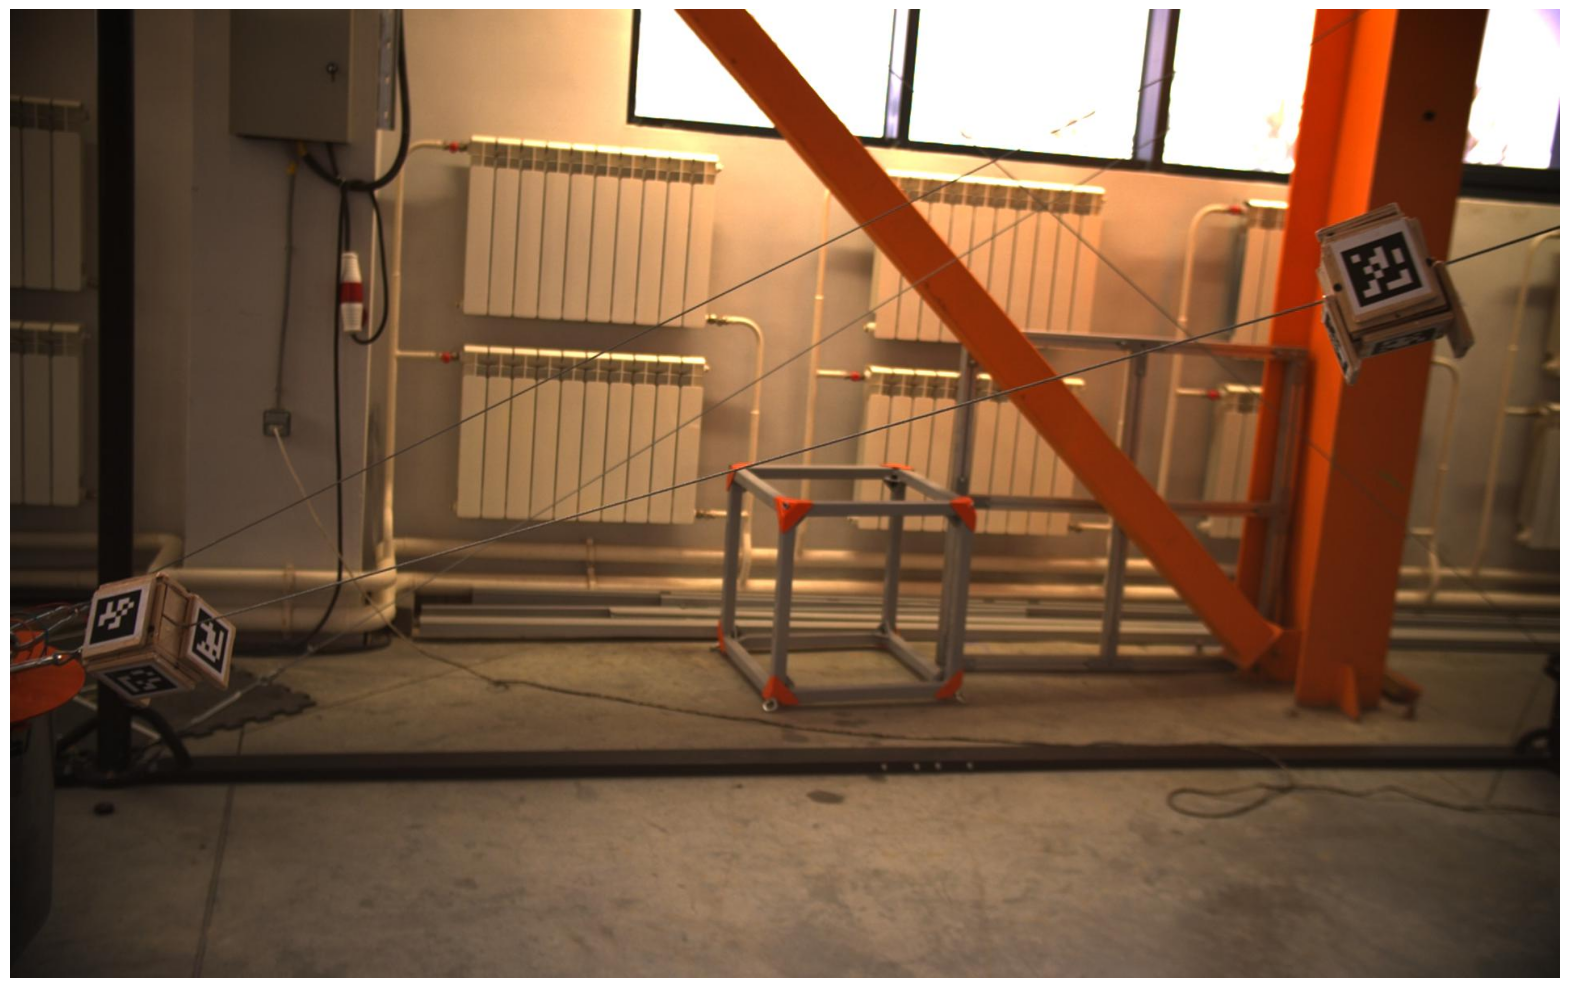

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())

103
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


Show all the masks overlayed on the image.

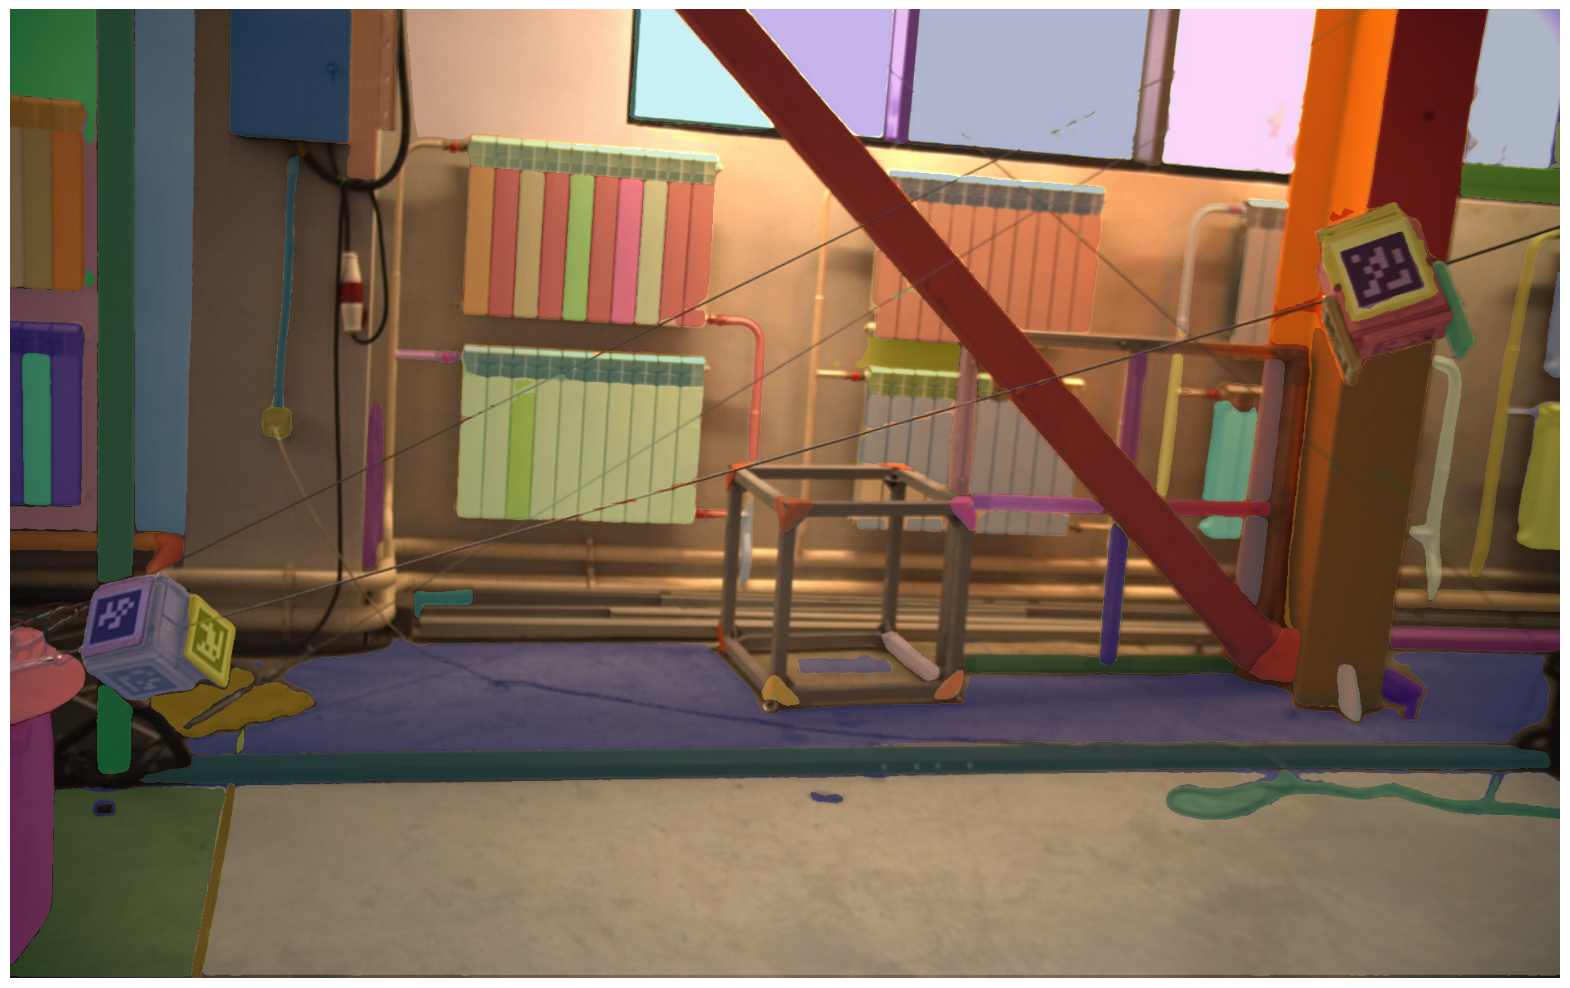

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [ ]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=.95,
    crop_n_layers=1,
    crop_n_points_downscale_factor=1,
    min_mask_region_area=1,  # Requires open-cv to run post-processing
)

In [ ]:
masks2 = mask_generator_2.generate(image)

In [ ]:
len(masks2)

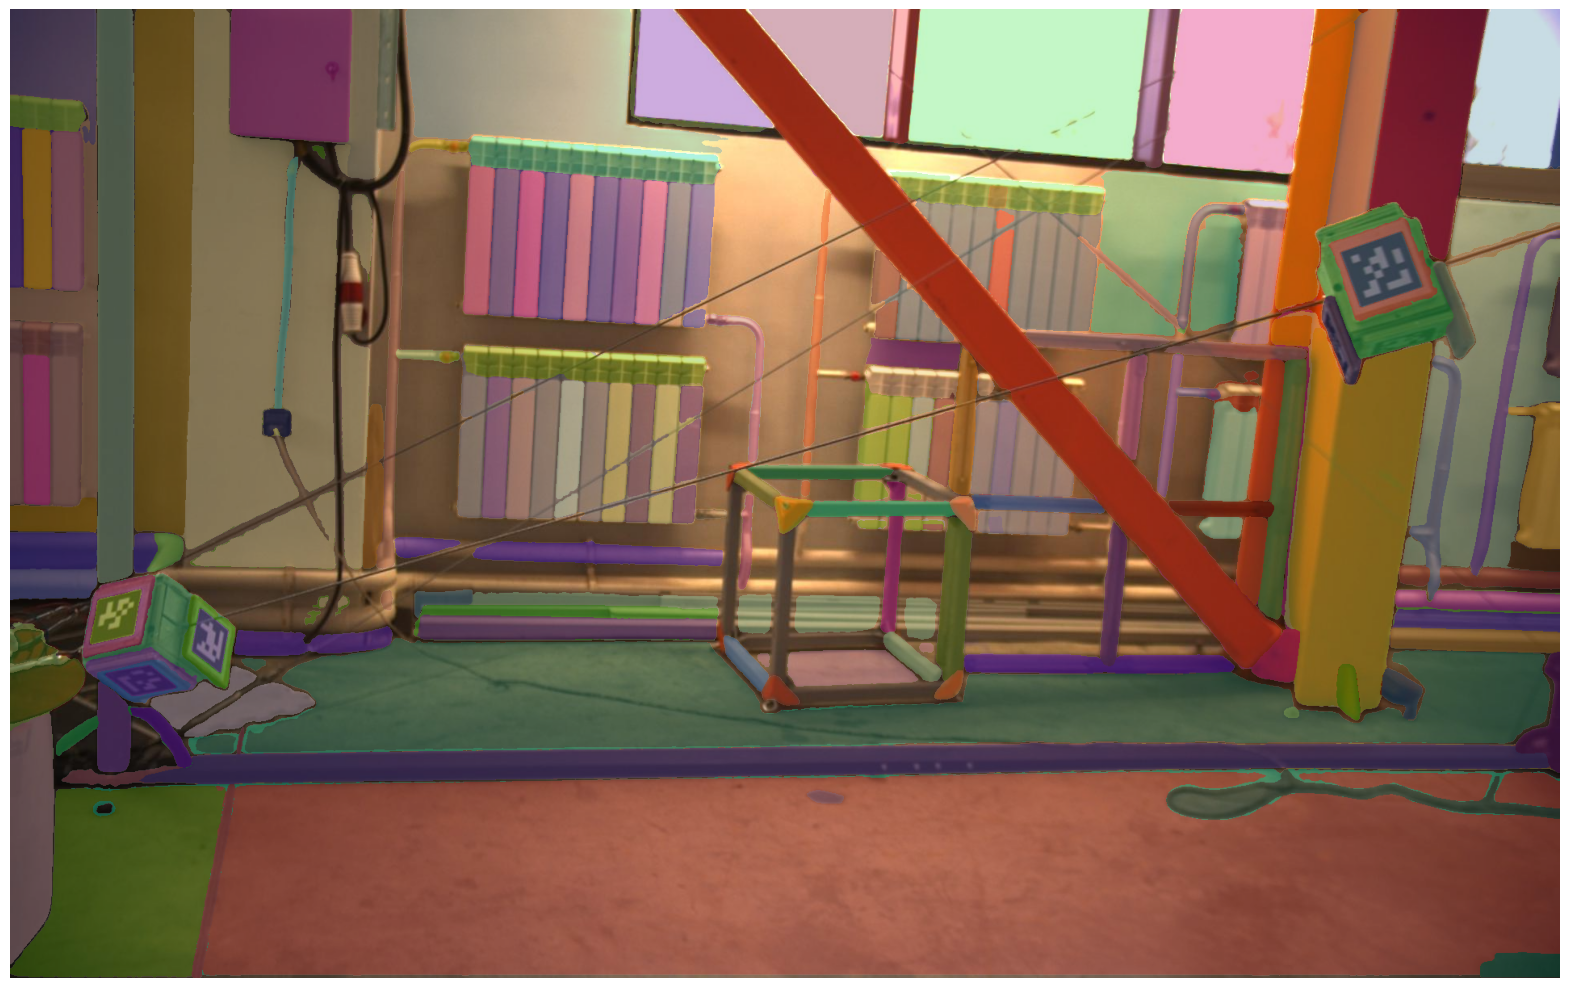

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show()

138


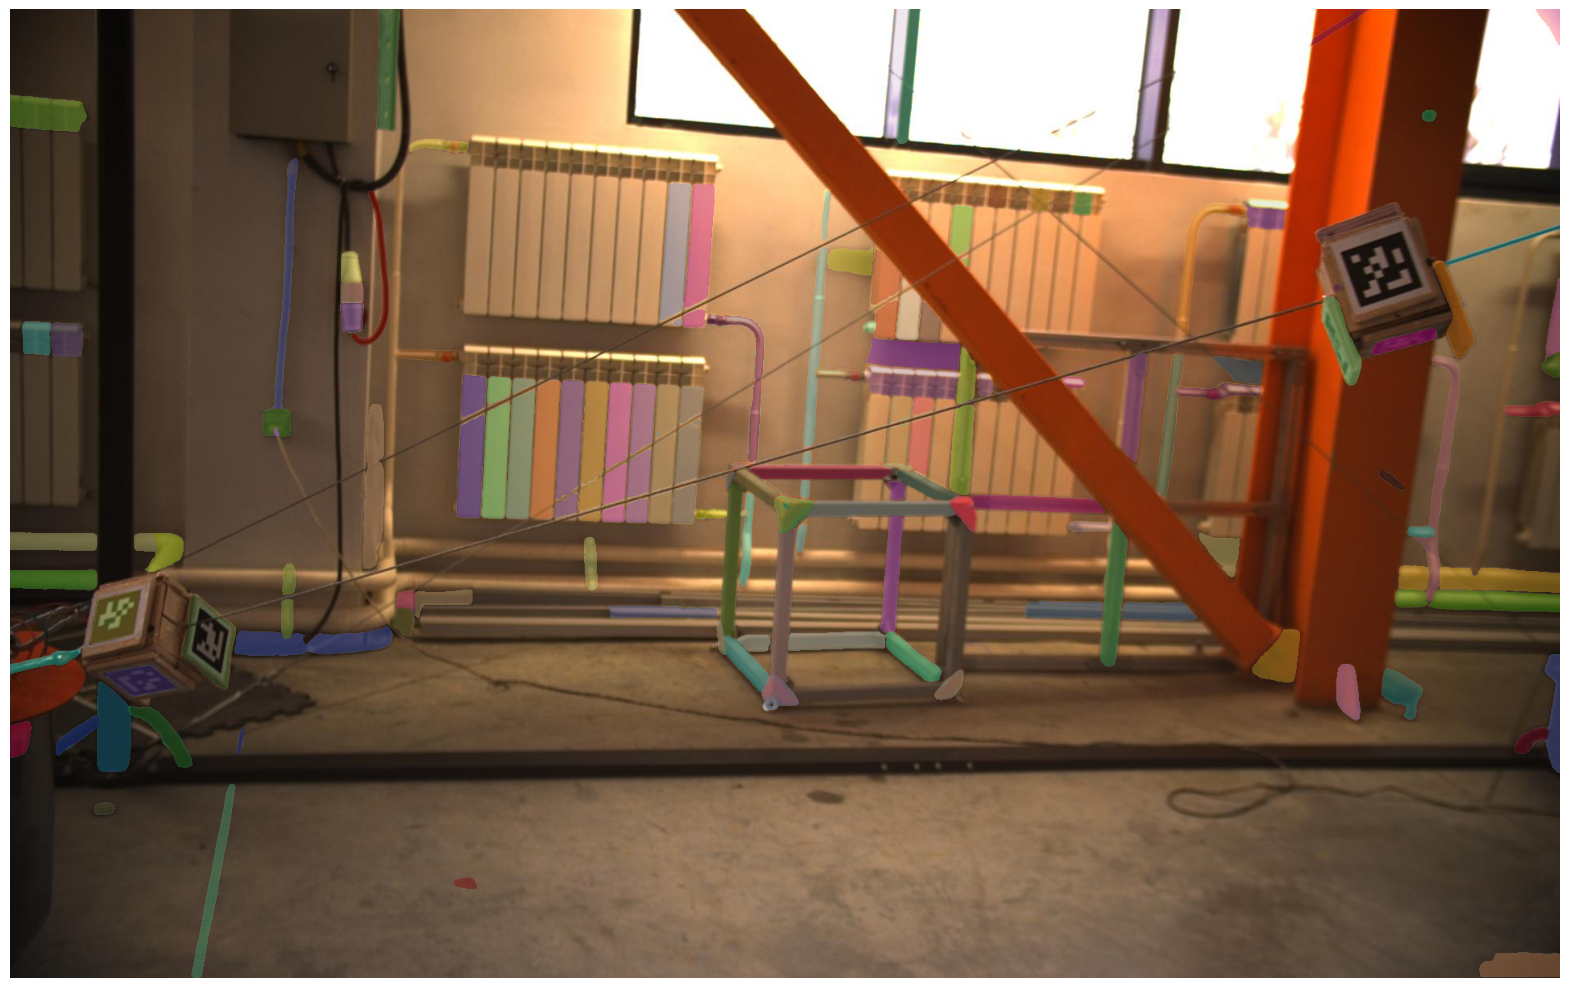

In [ ]:
def show_anns(anns, min_area_threshold):
    if len(anns) == 0:
        return

    filtered_anns = [ann for ann in anns if ann['area'] <= min_area_threshold]

    print(len(filtered_anns))
    if len(filtered_anns) == 0:
        return

    sorted_anns = sorted(filtered_anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# Define the minimum area threshold
min_area_threshold = 5000  # Adjust this value as needed

# Call show_anns function with the minimum area threshold
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2, min_area_threshold)
plt.axis('off')
plt.show()


102


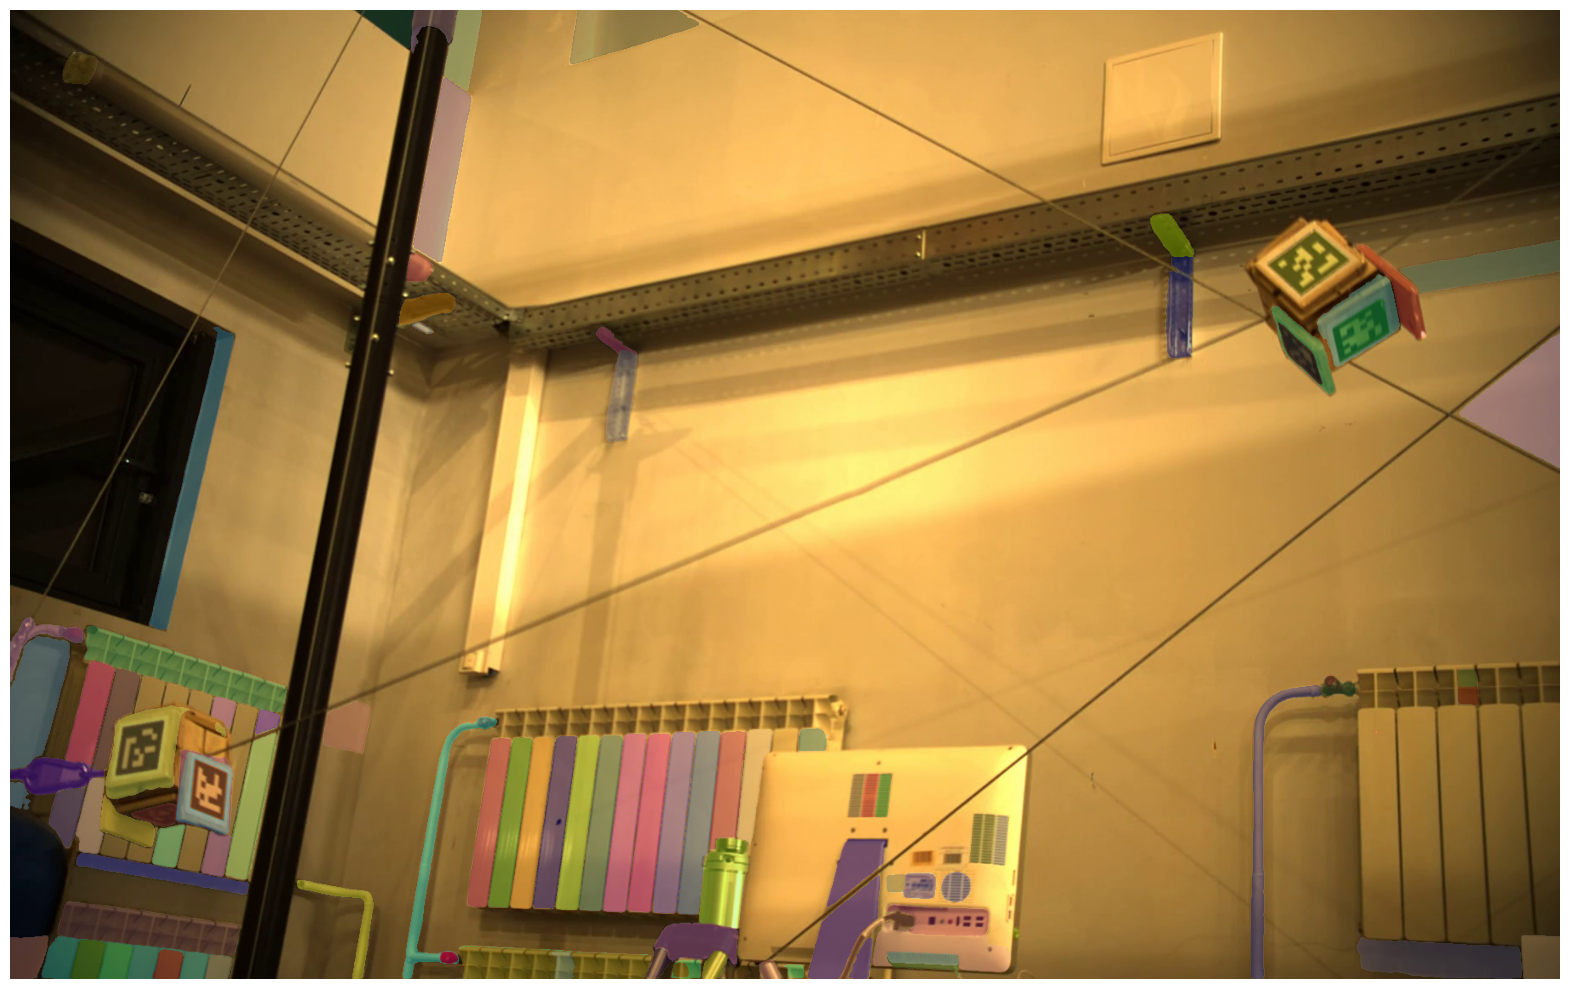

In [ ]:
def show_anns(anns, min_area_threshold):
    if len(anns) == 0:
        return

    filtered_anns = [ann for ann in anns if ann['area'] <= min_area_threshold]

    print(len(filtered_anns))
    if len(filtered_anns) == 0:
        return

    sorted_anns = sorted(filtered_anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

# Define the minimum area threshold
min_area_threshold = 10000  # Adjust this value as needed

# Call show_anns function with the minimum area threshold
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2, min_area_threshold)
plt.axis('off')
plt.show()


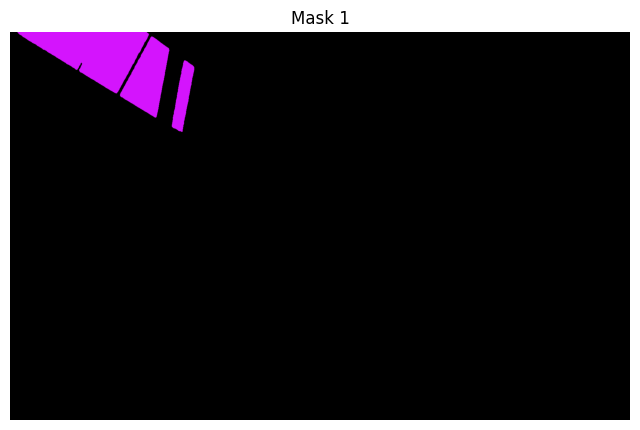

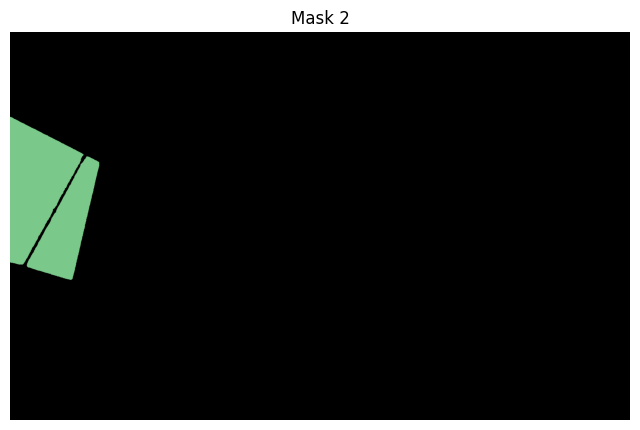

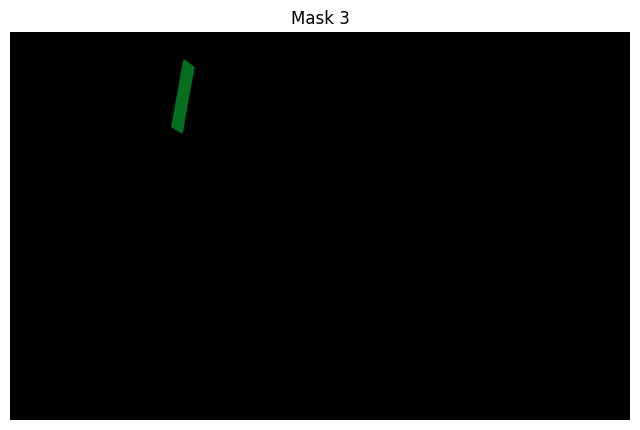

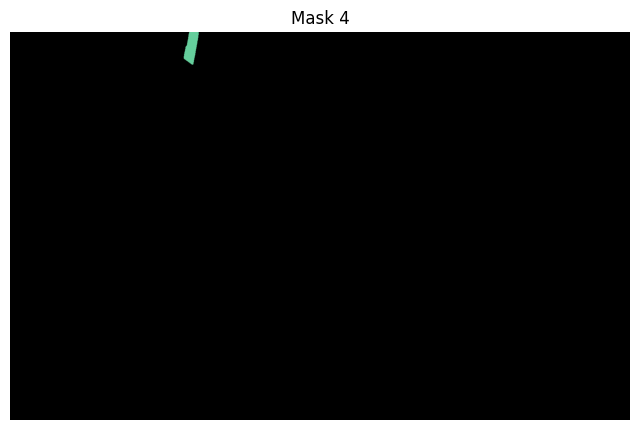

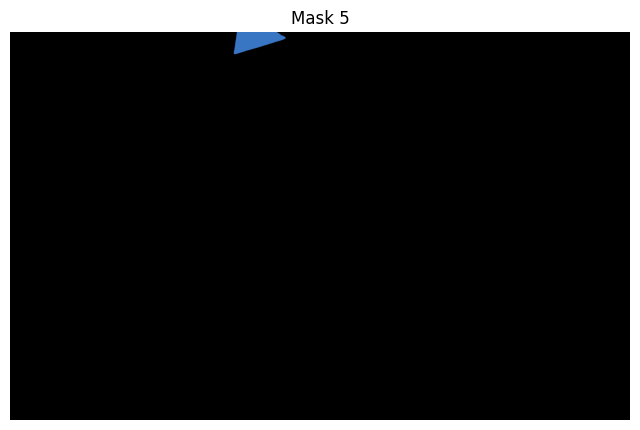

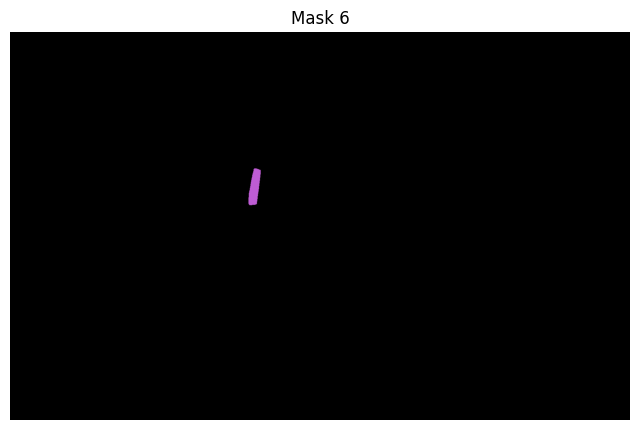

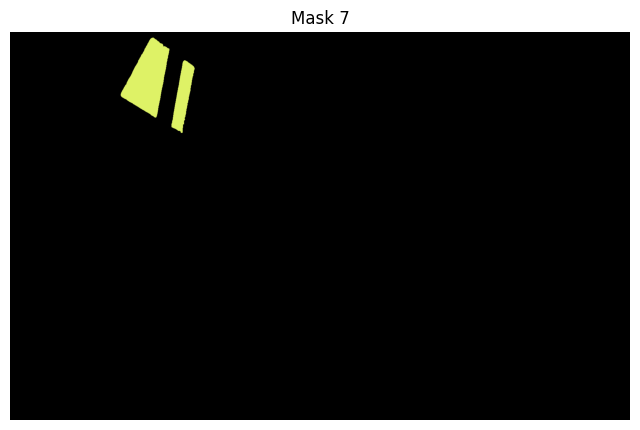

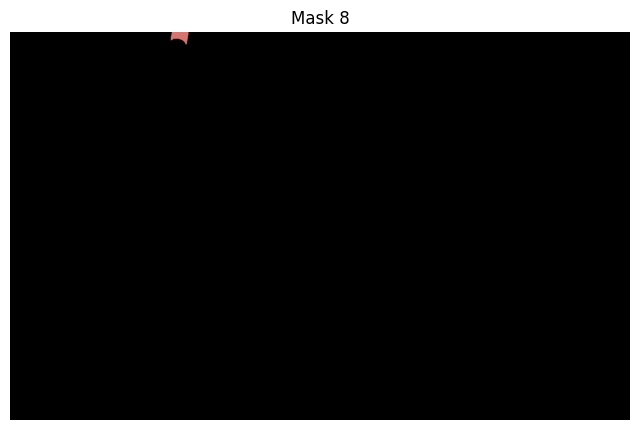

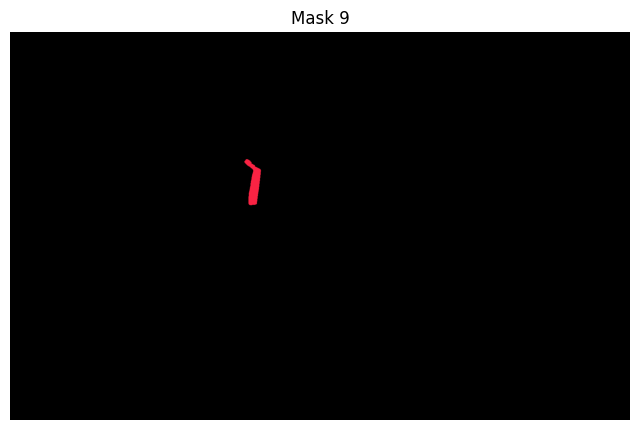

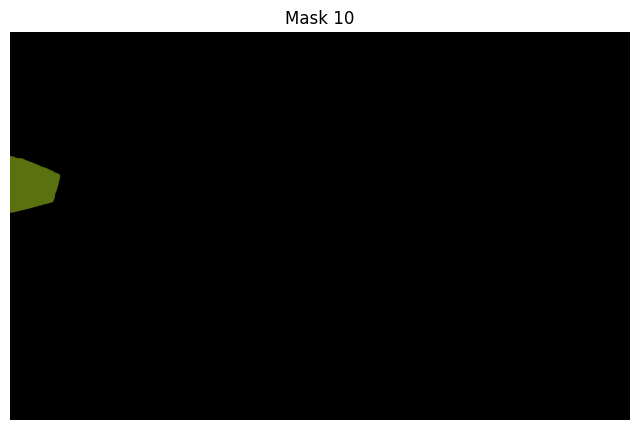

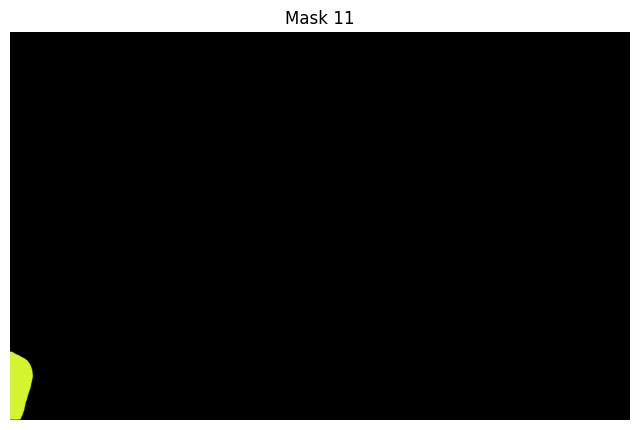

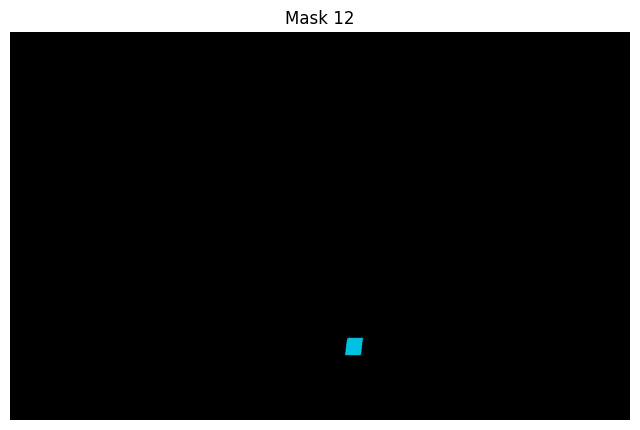

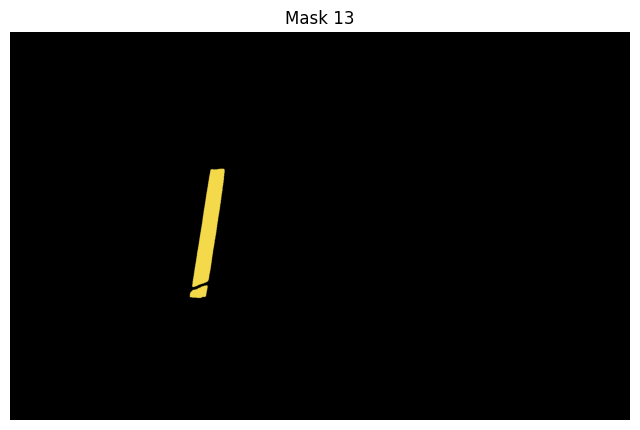

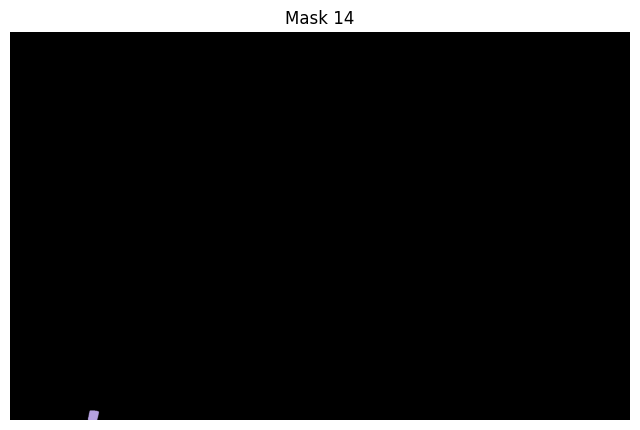

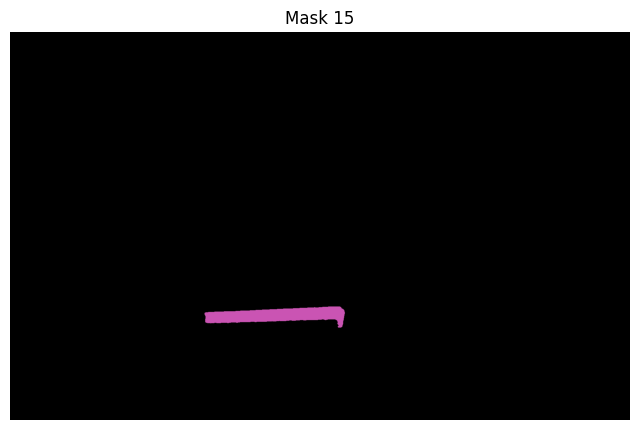

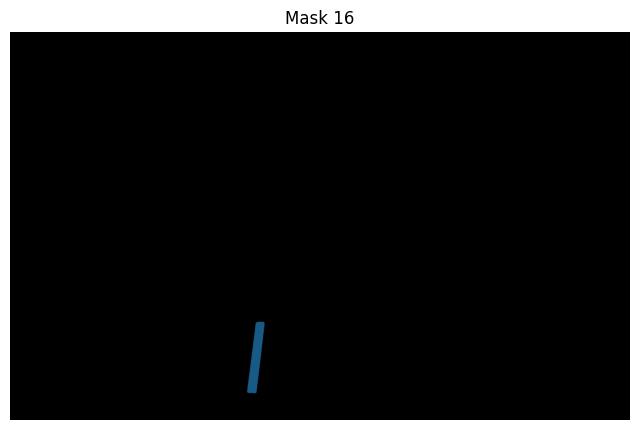

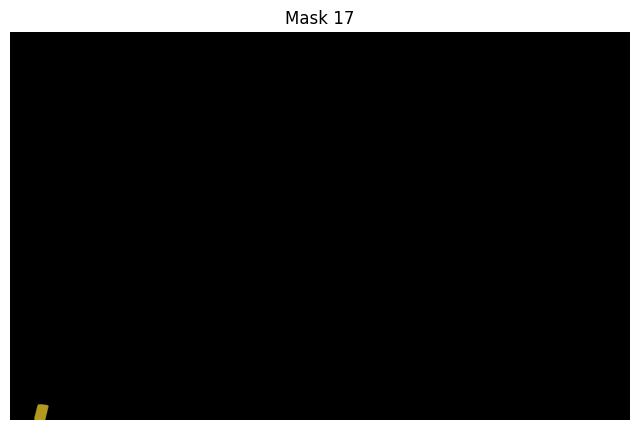

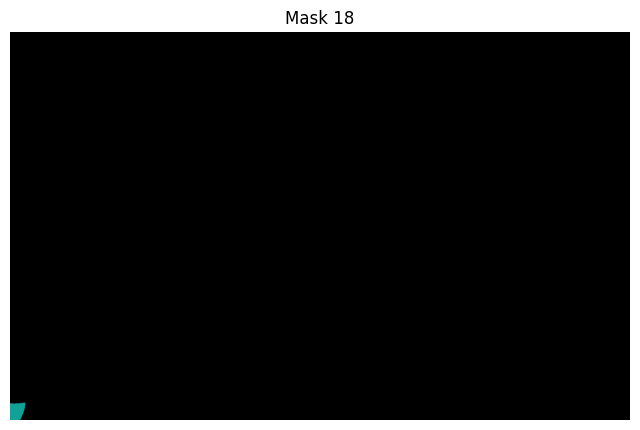

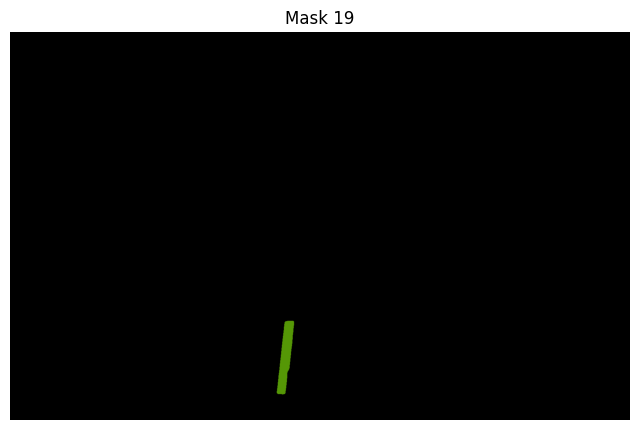

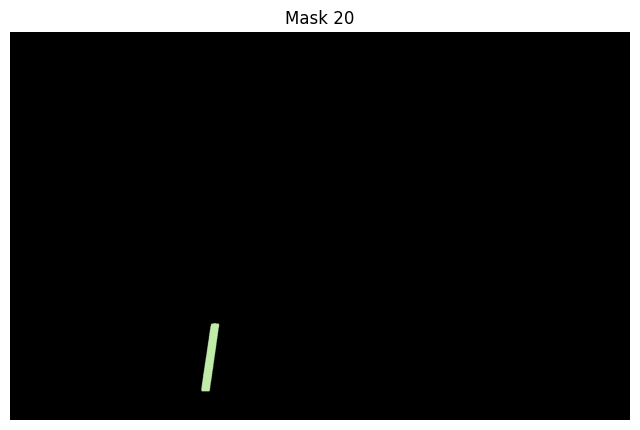

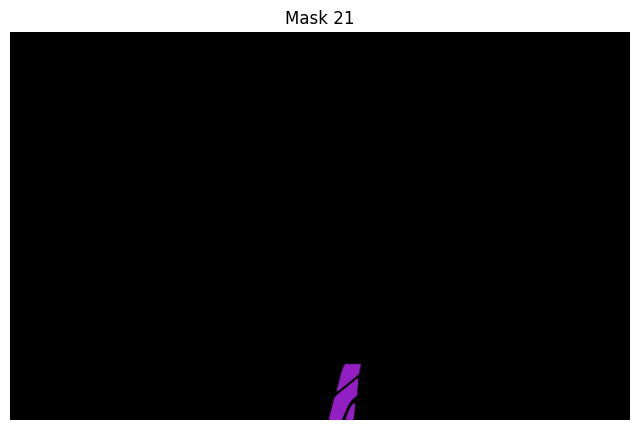

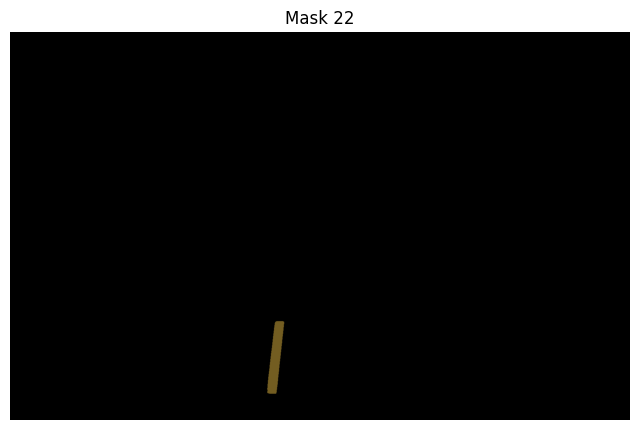

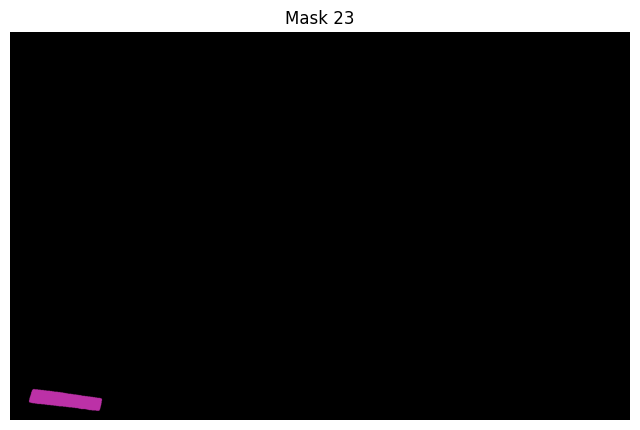

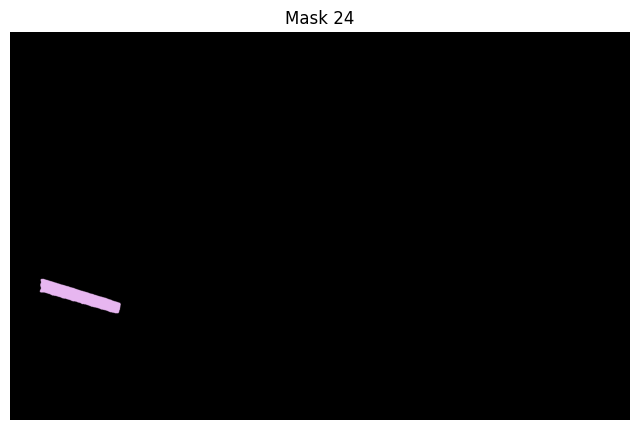

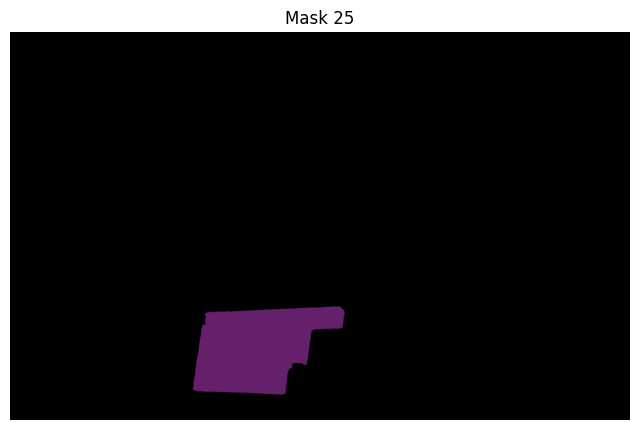

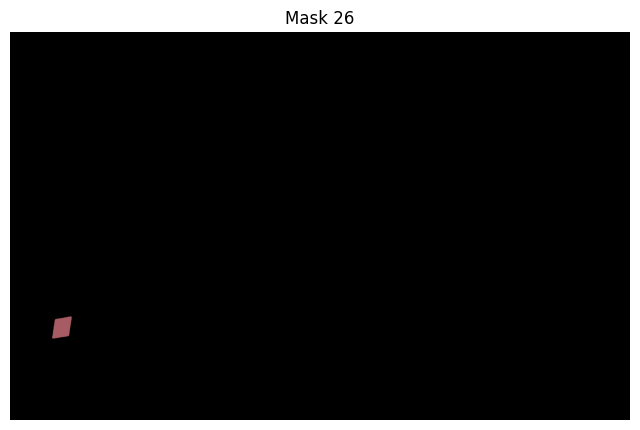

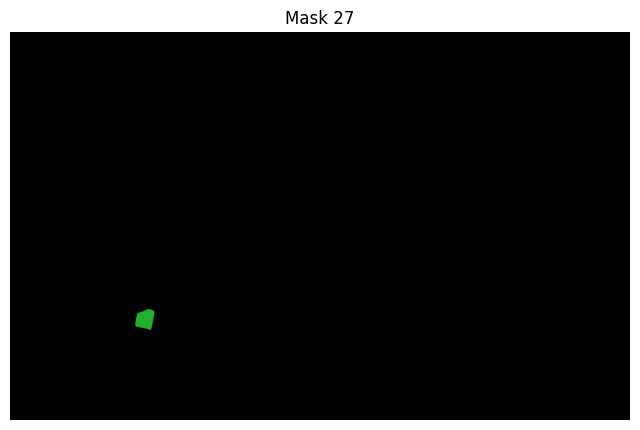

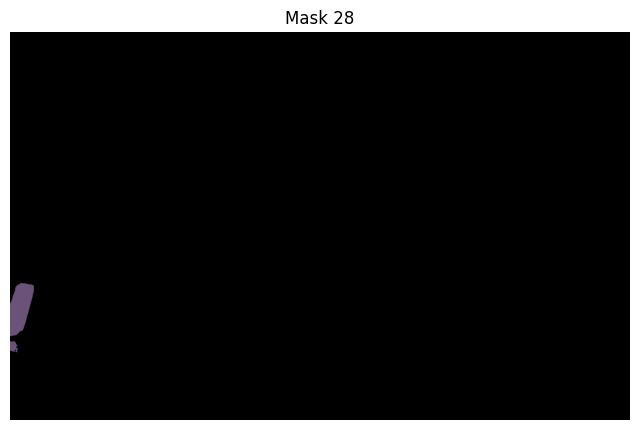

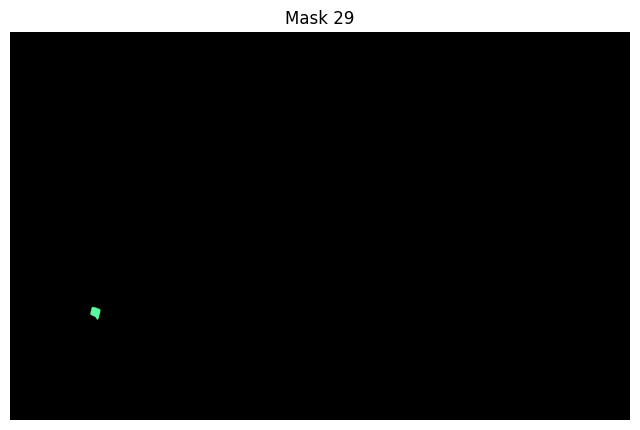

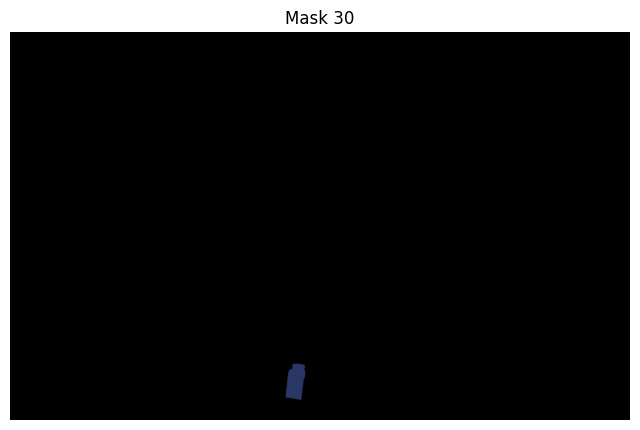

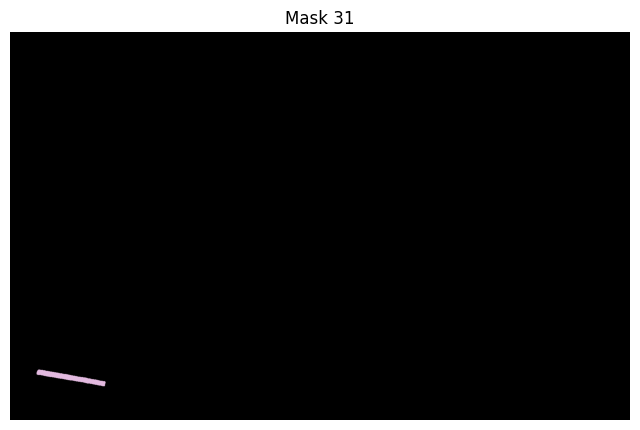

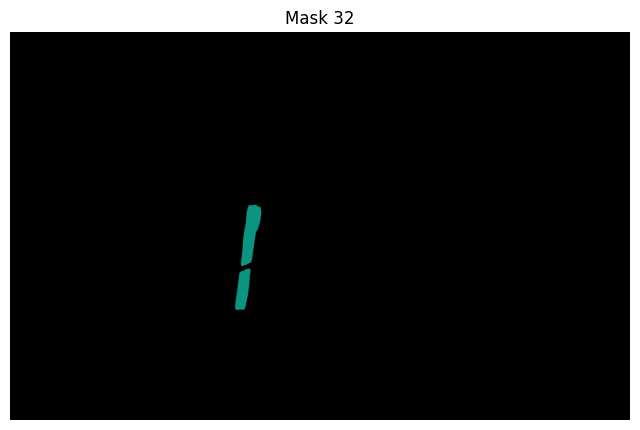

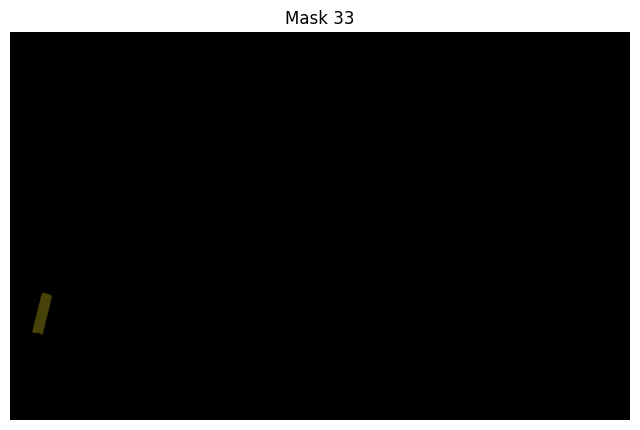

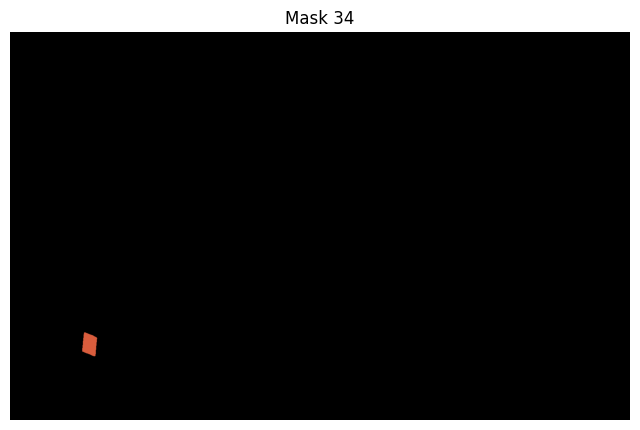

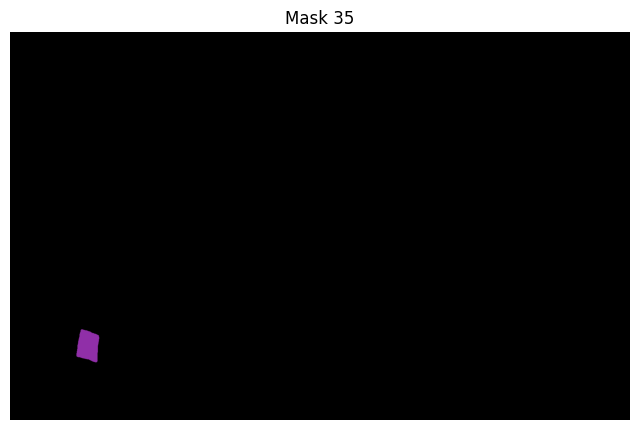

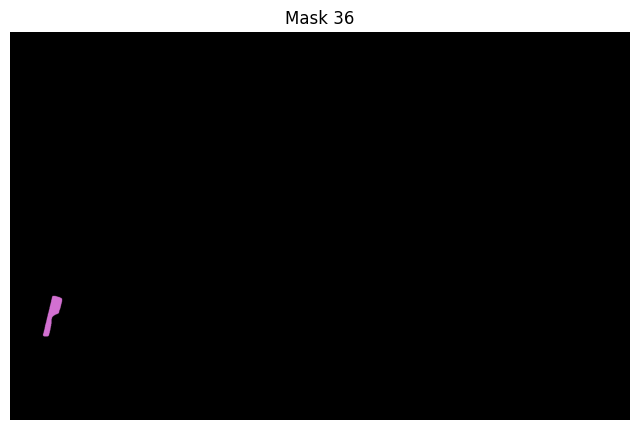

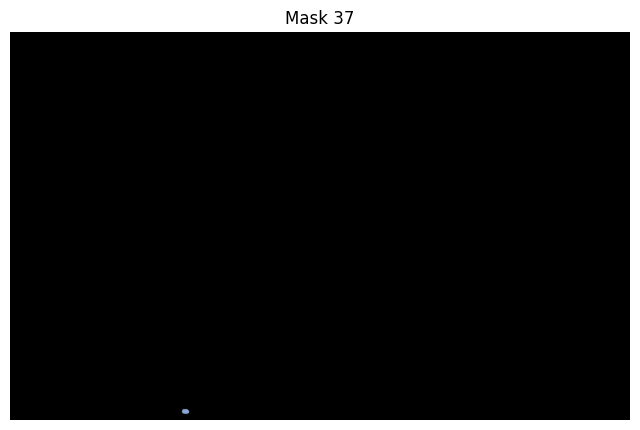

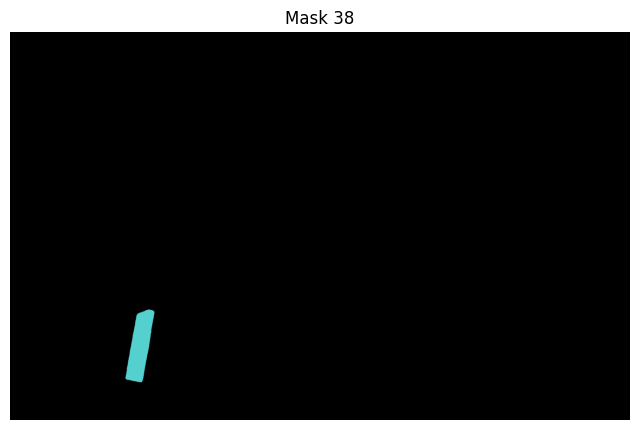

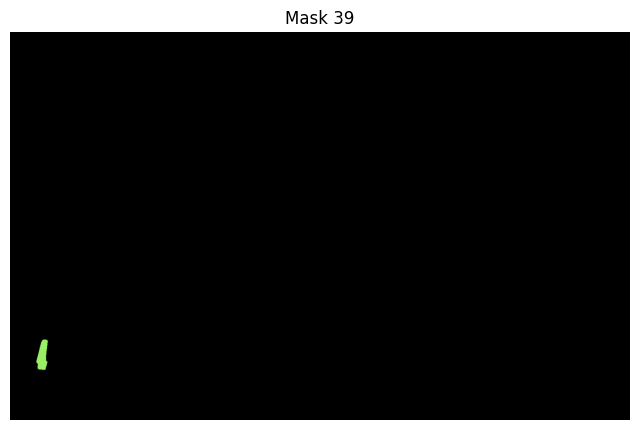

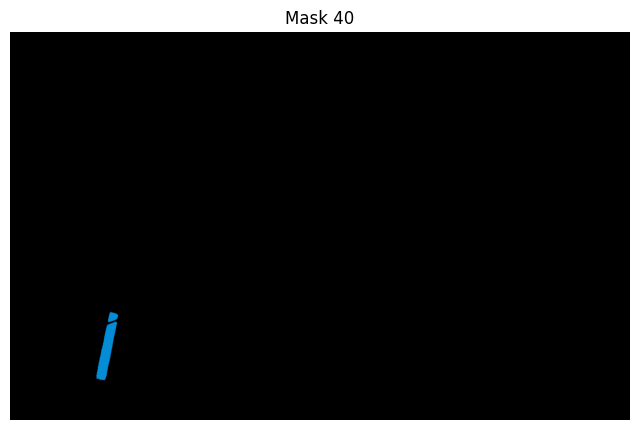

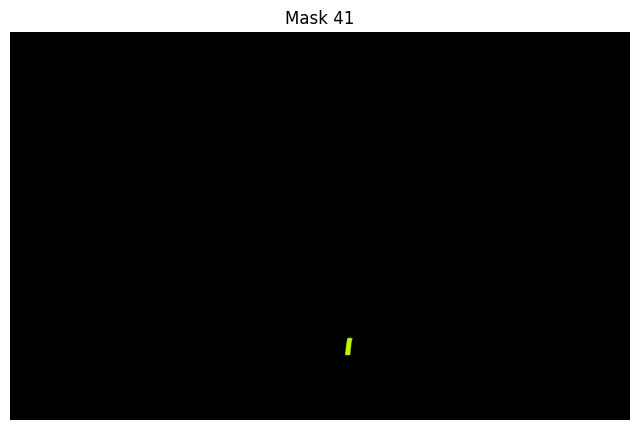

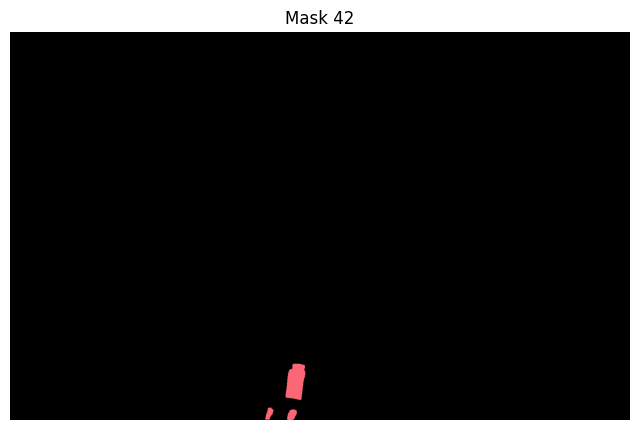

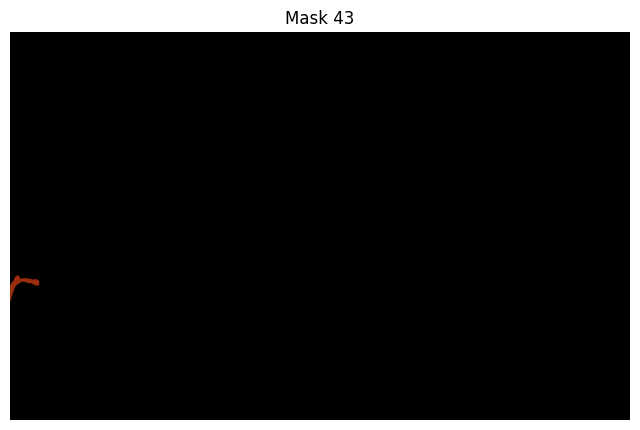

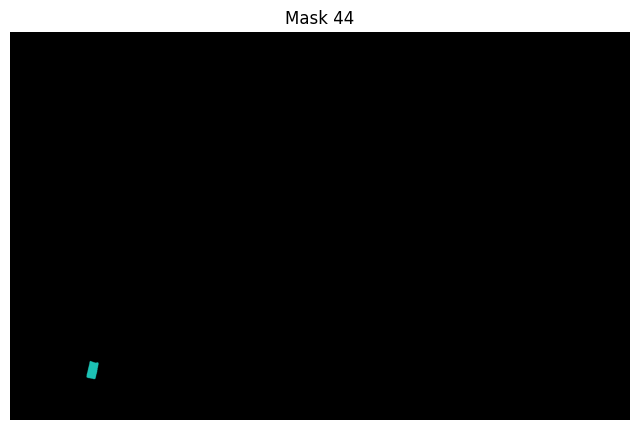

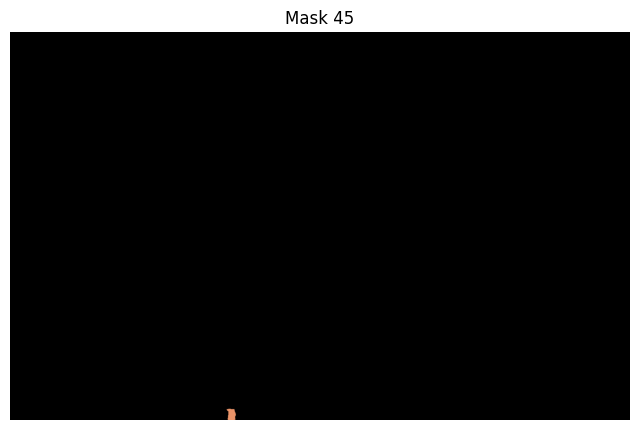

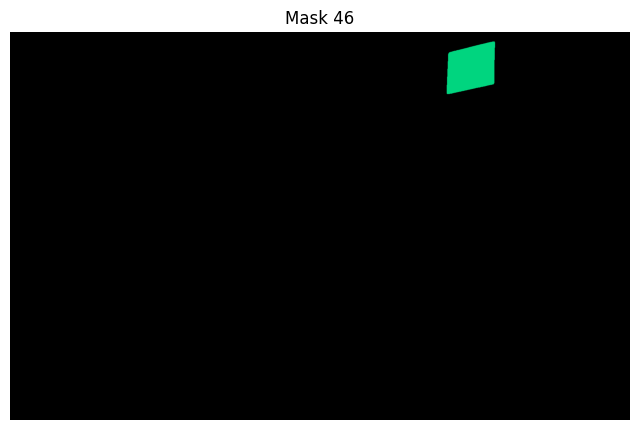

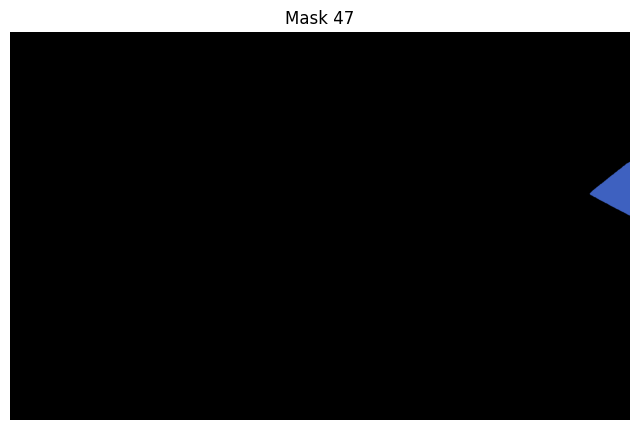

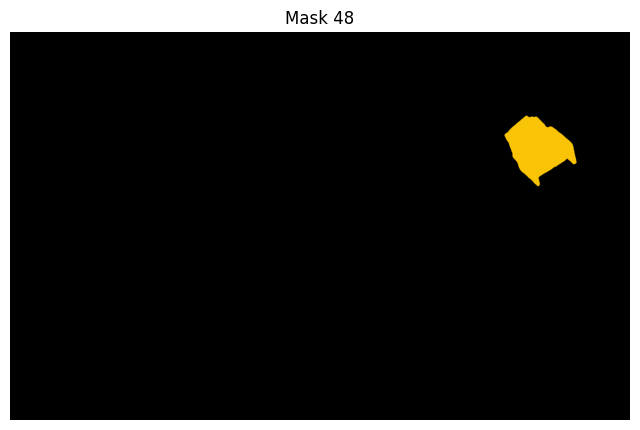

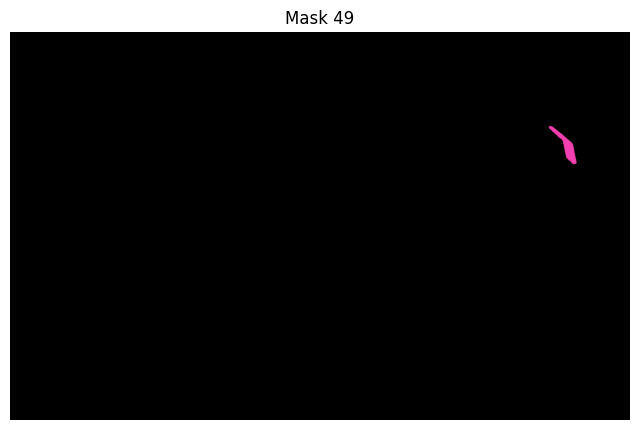

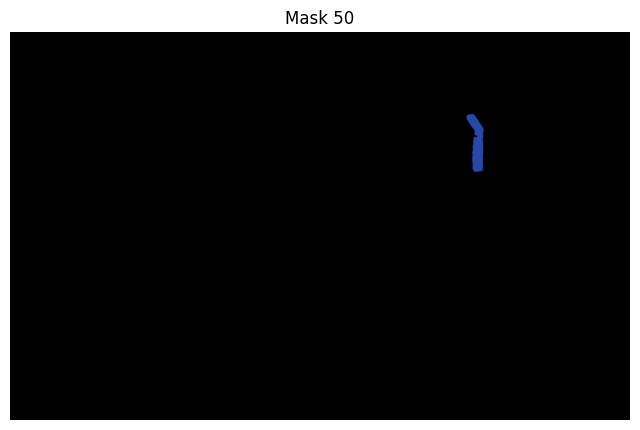

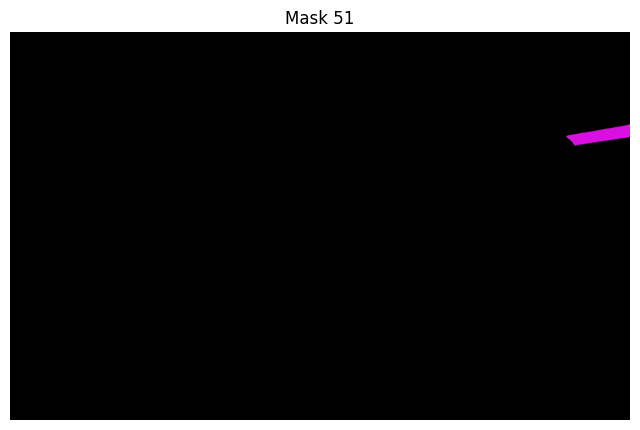

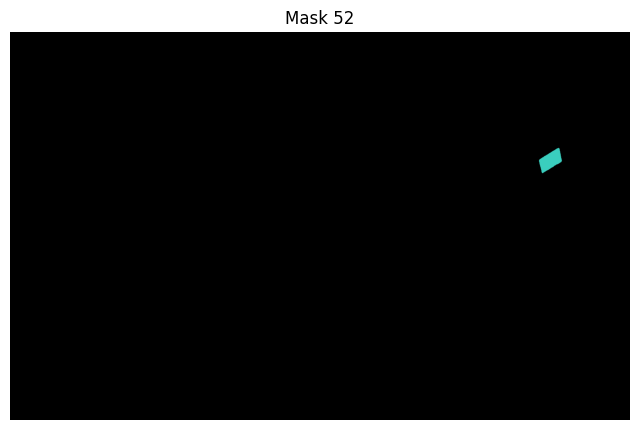

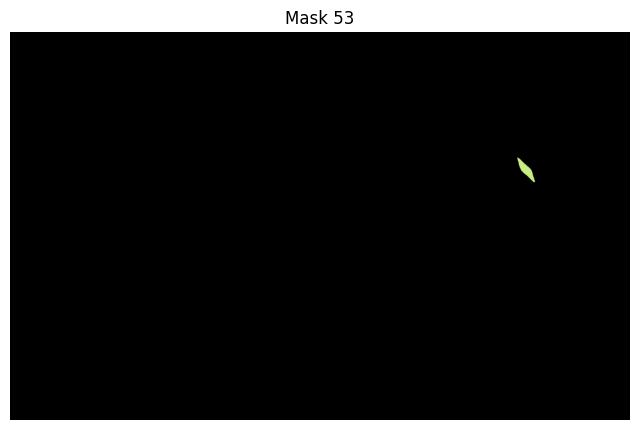

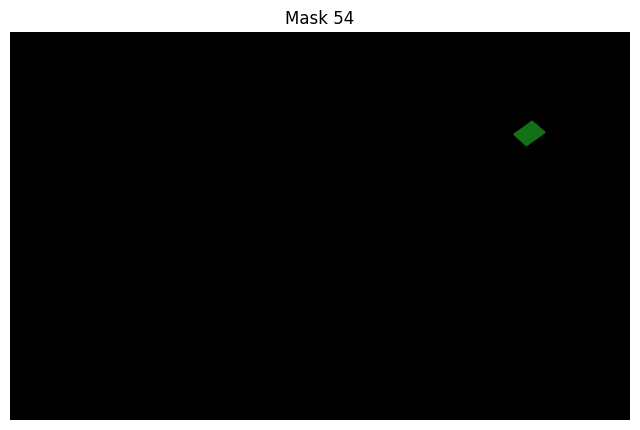

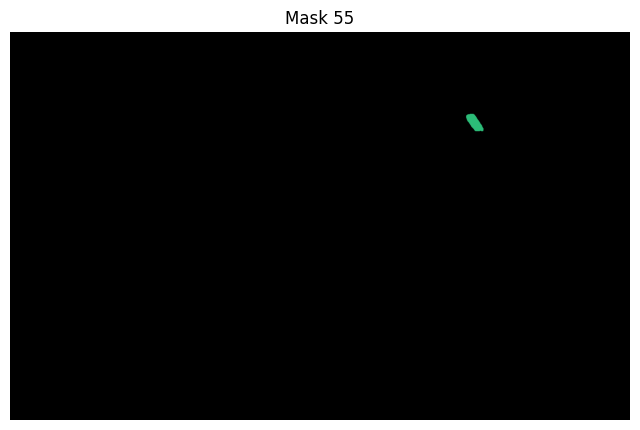

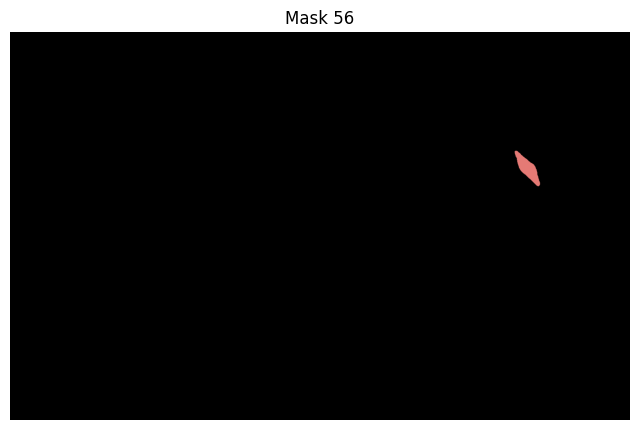

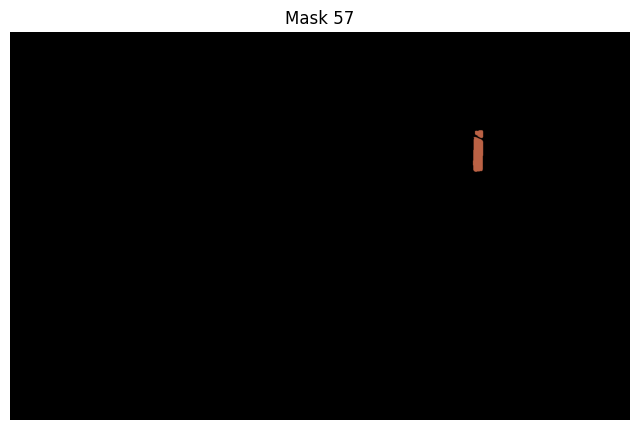

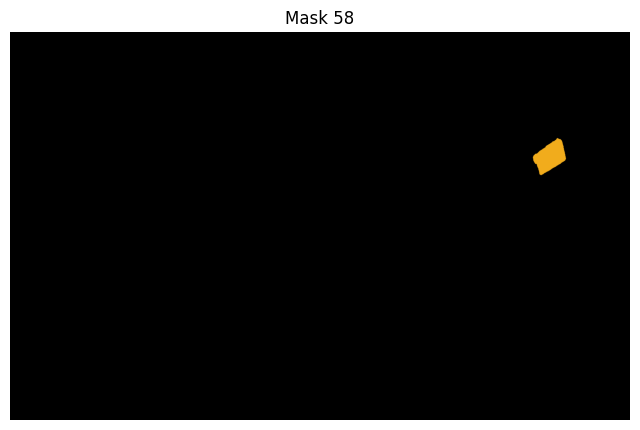

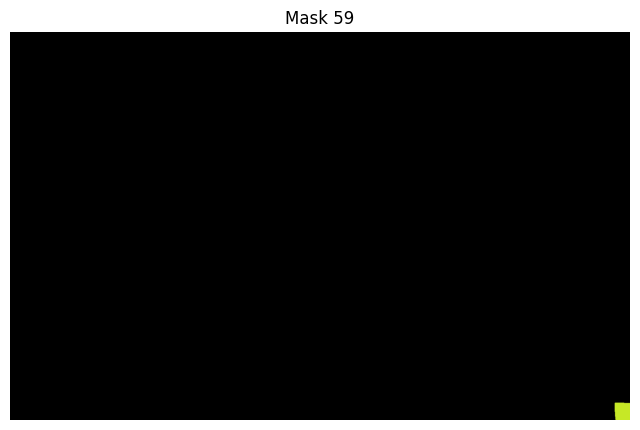

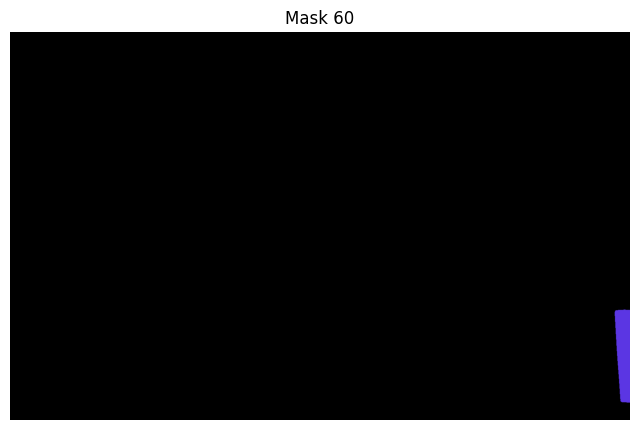

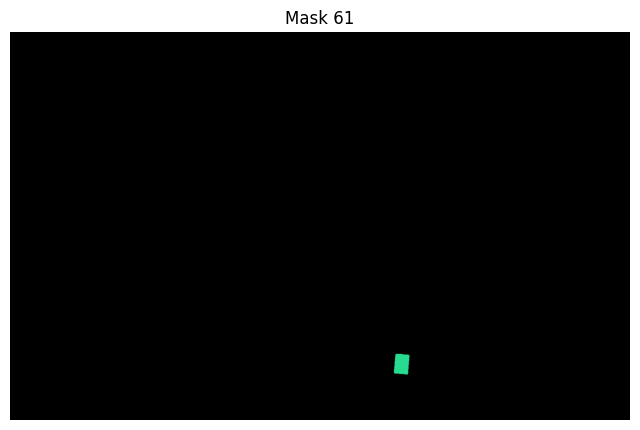

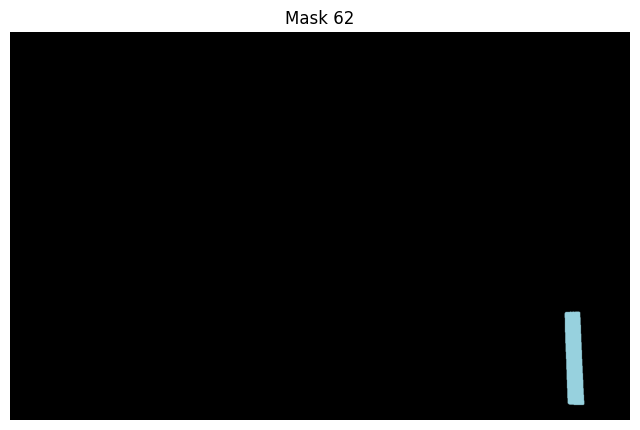

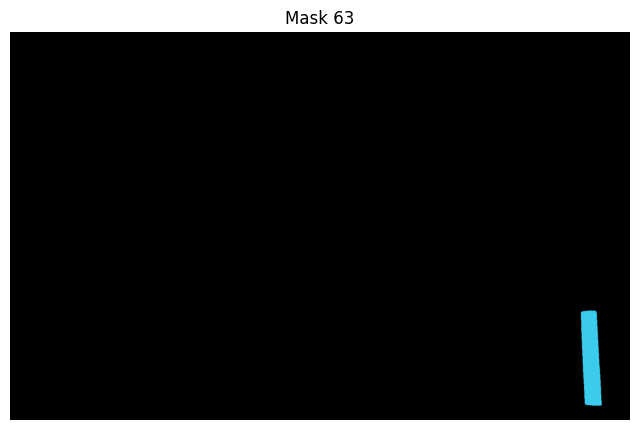

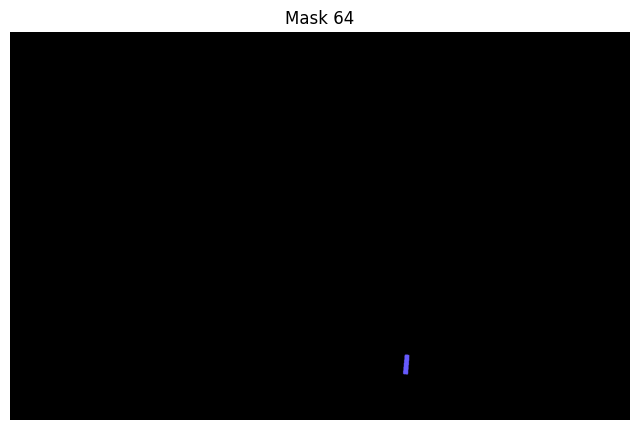

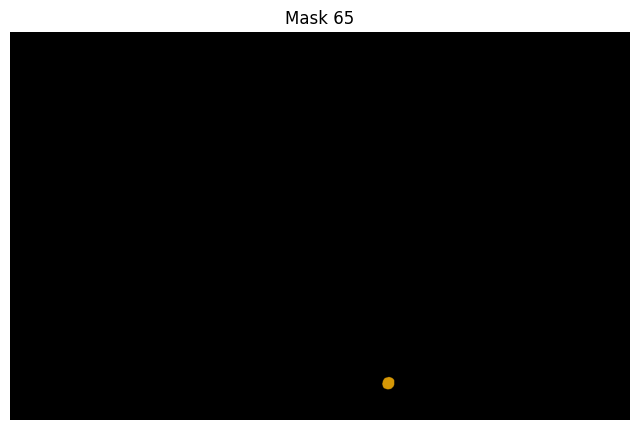

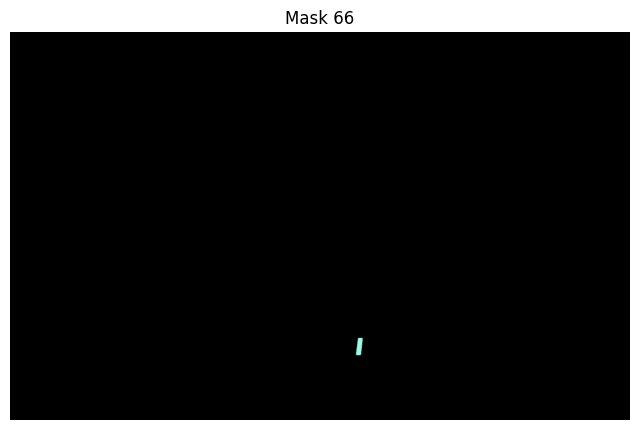

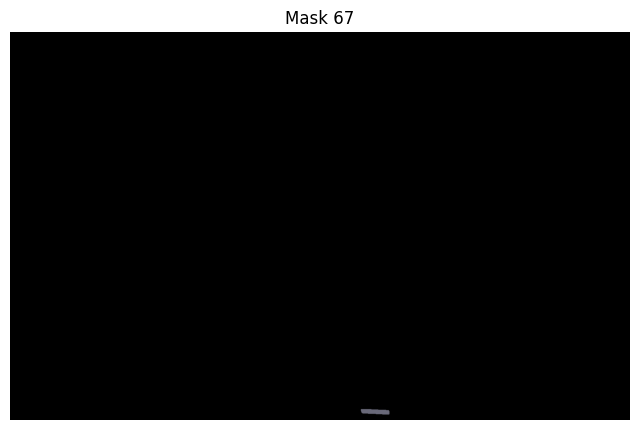

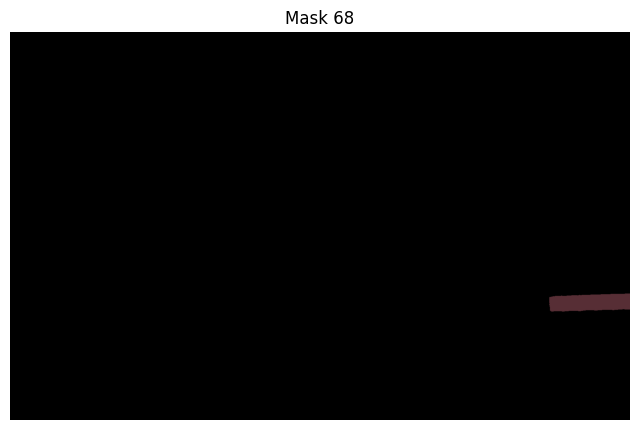

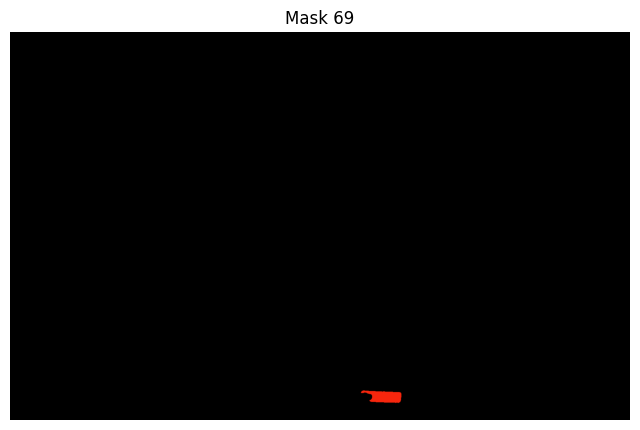

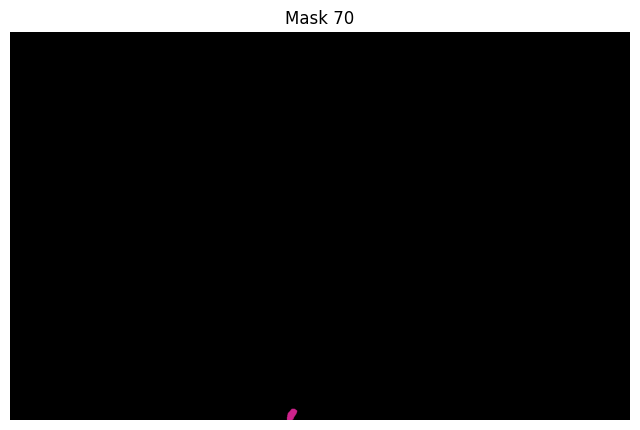

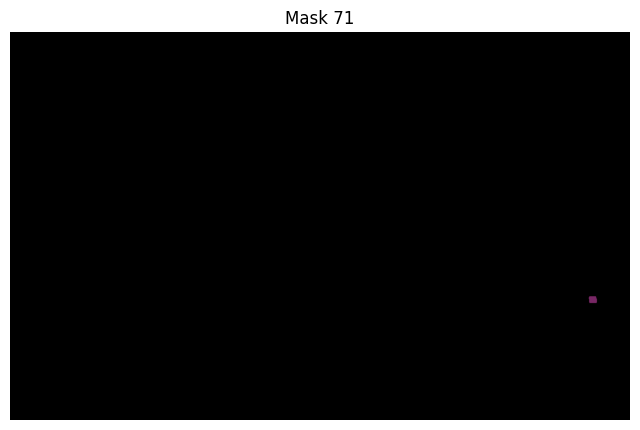

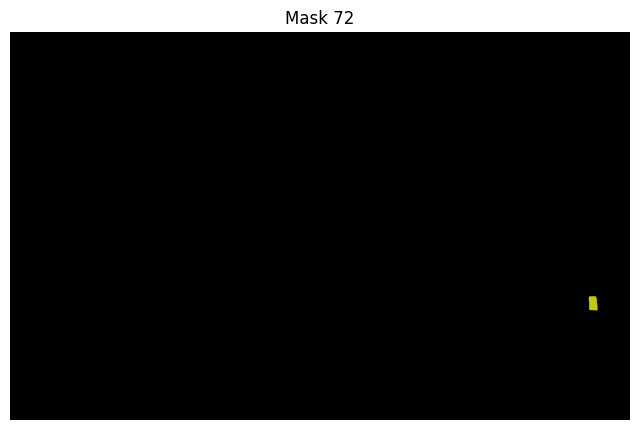

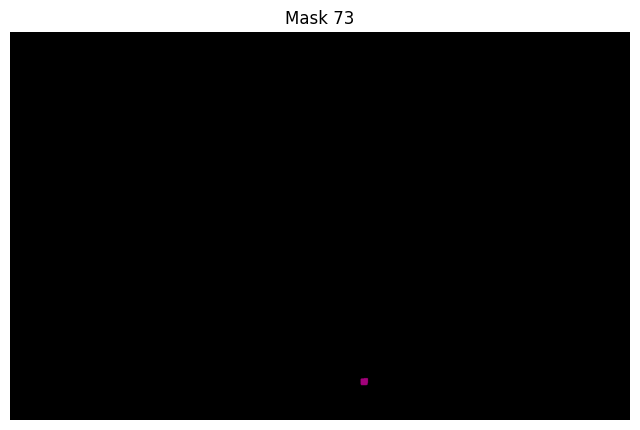

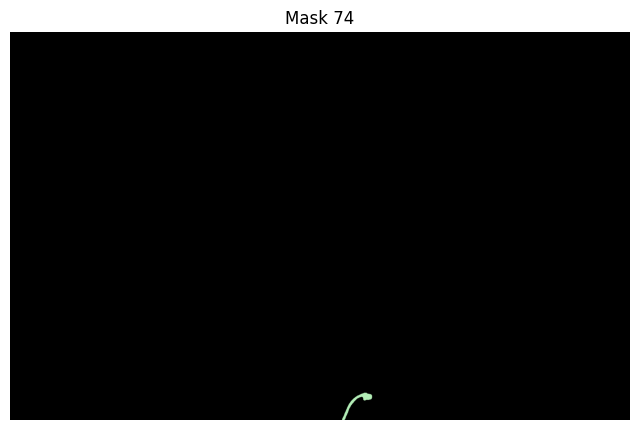

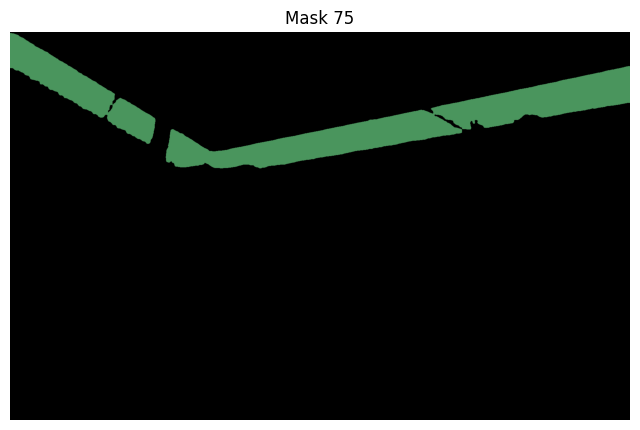

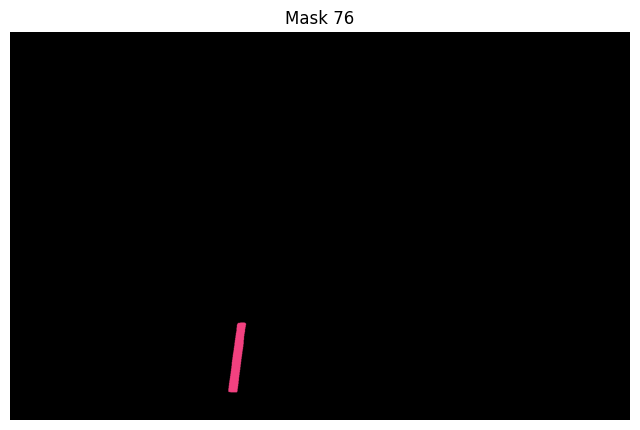

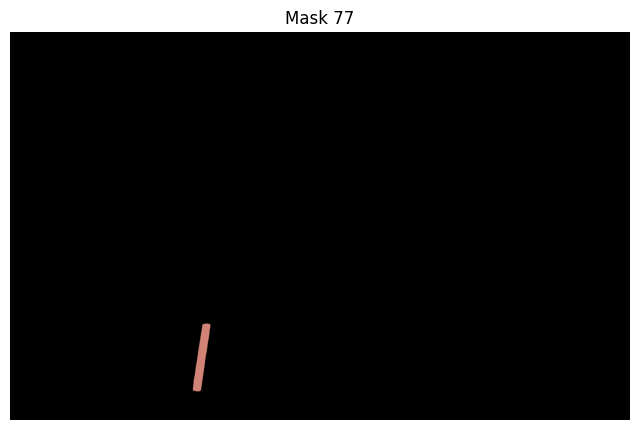

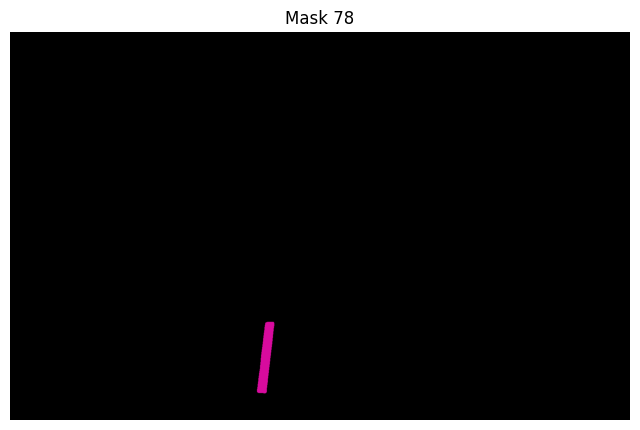

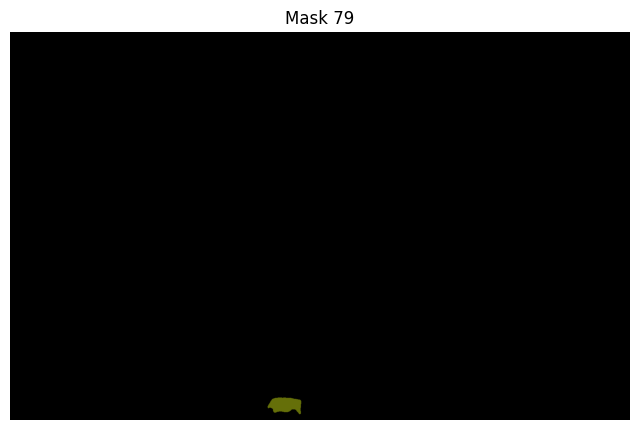

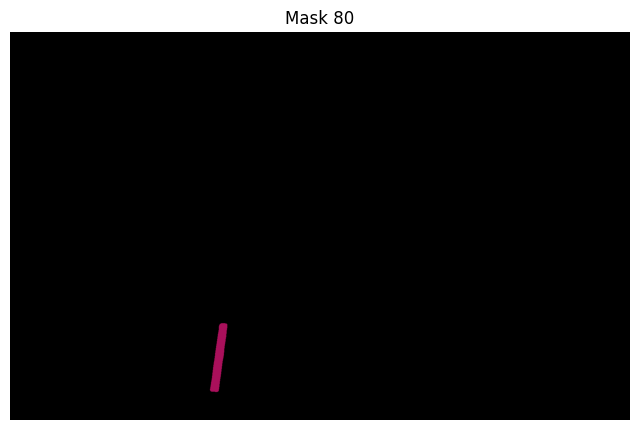

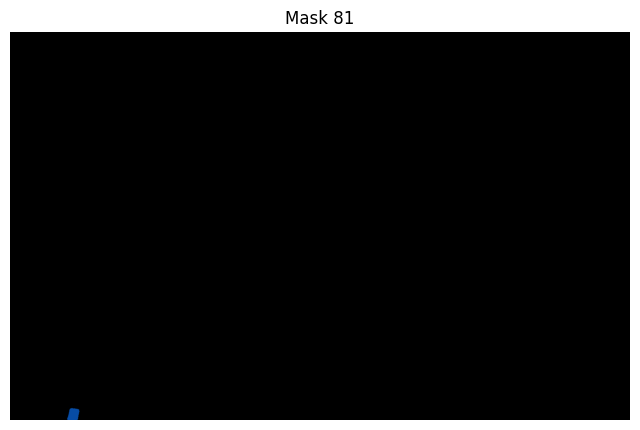

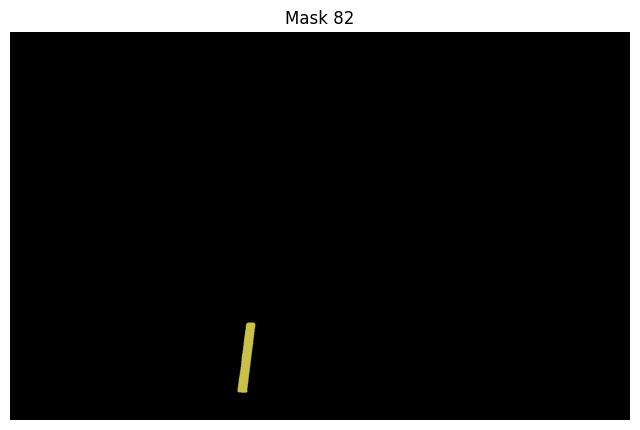

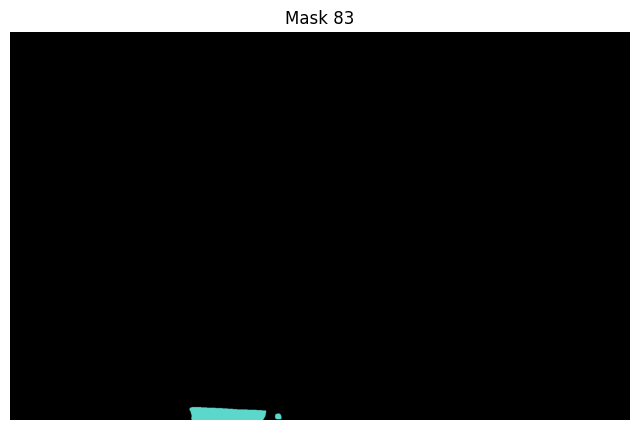

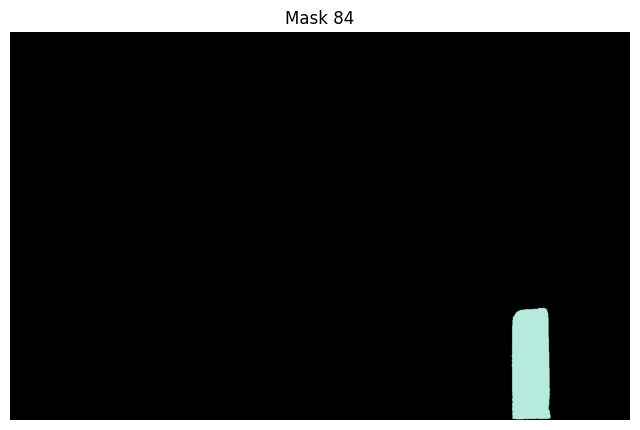

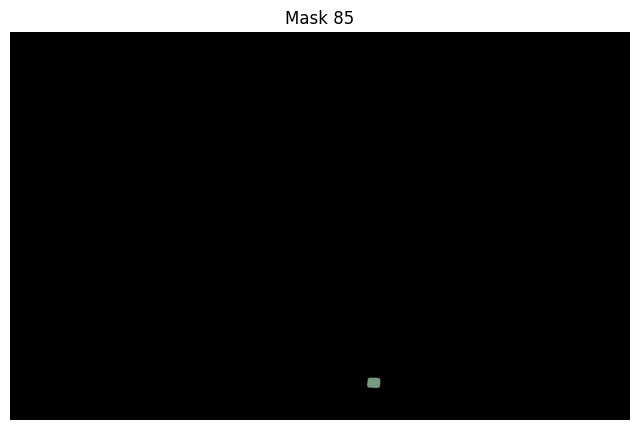

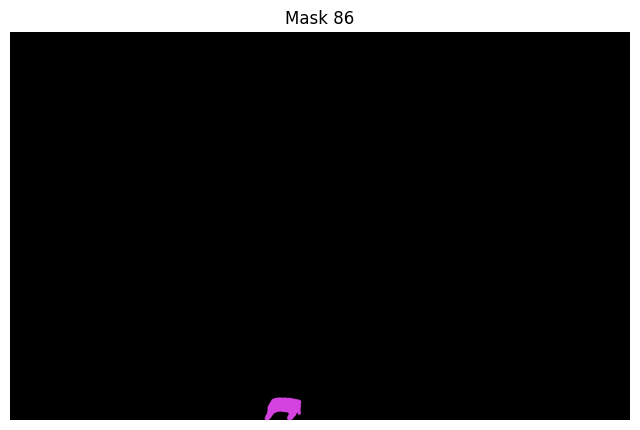

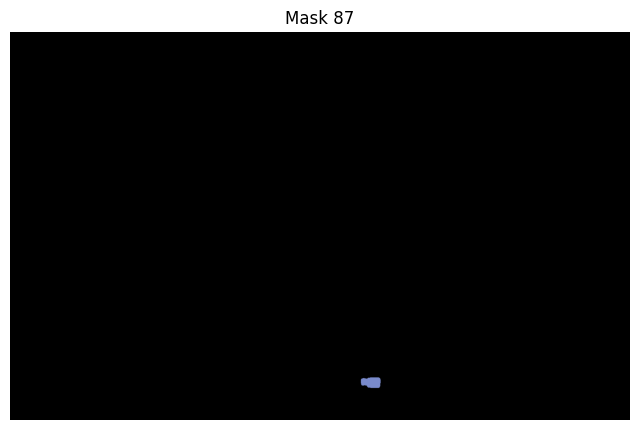

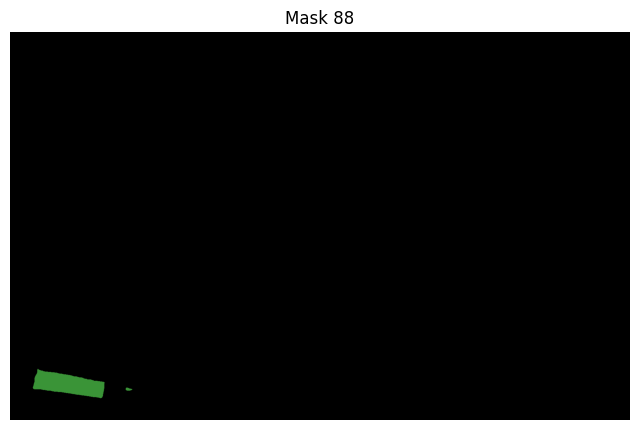

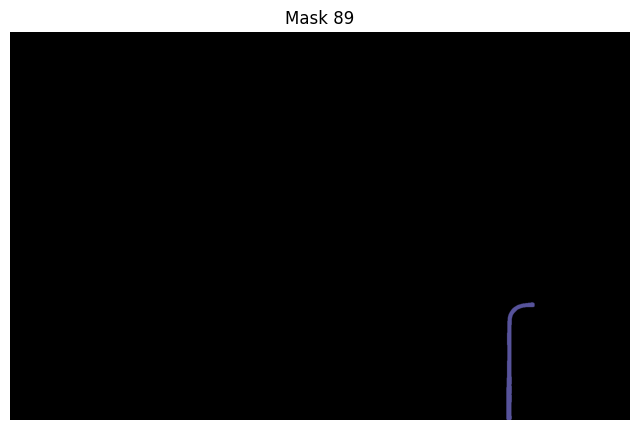

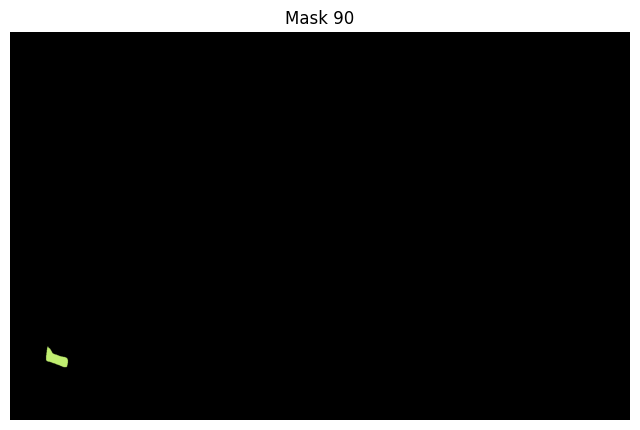

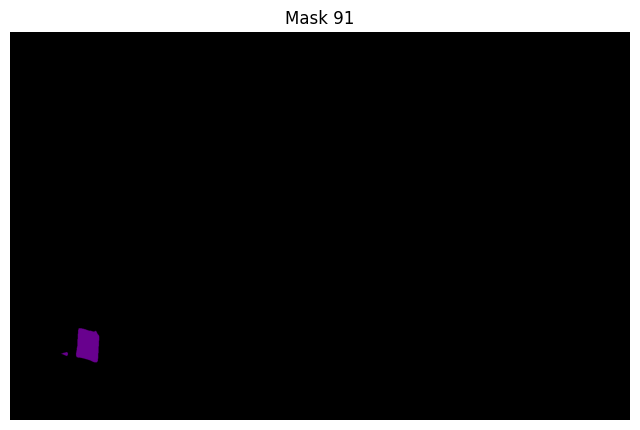

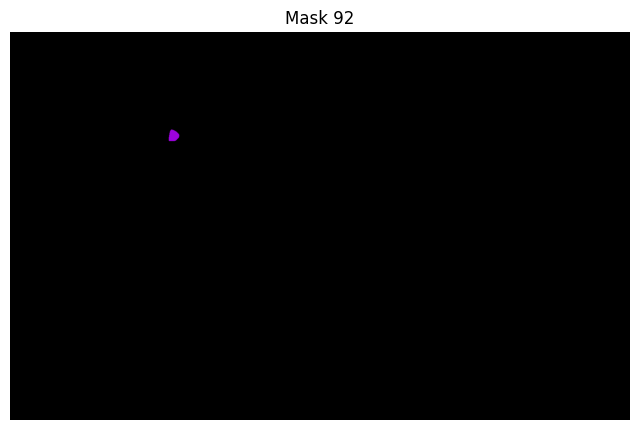

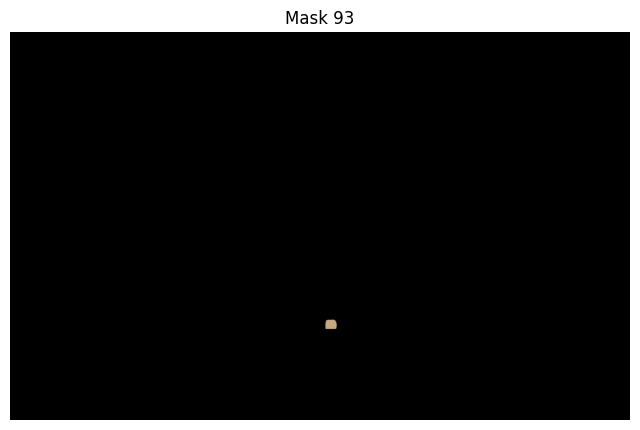

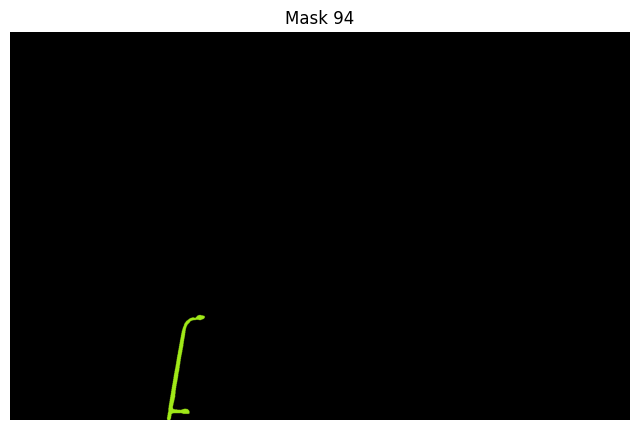

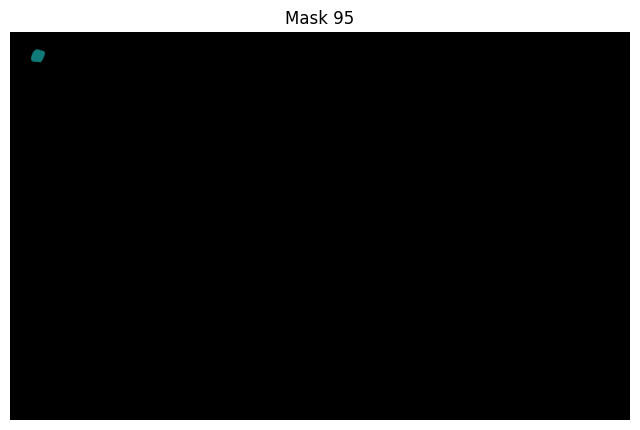

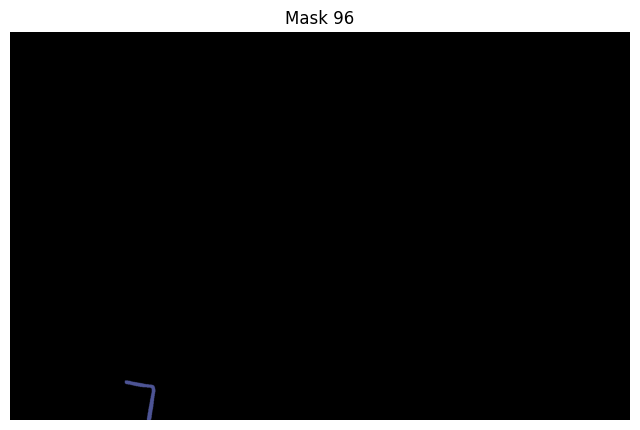

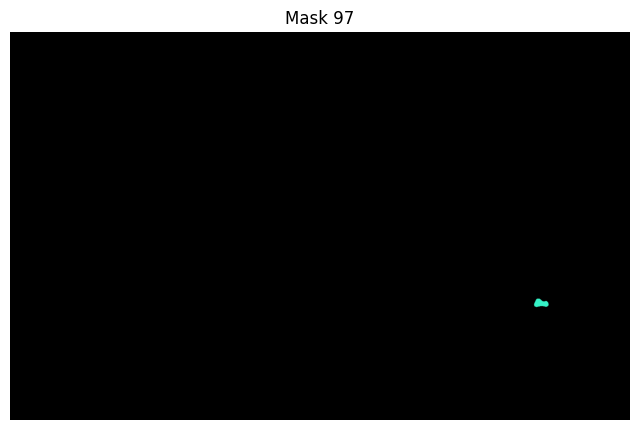

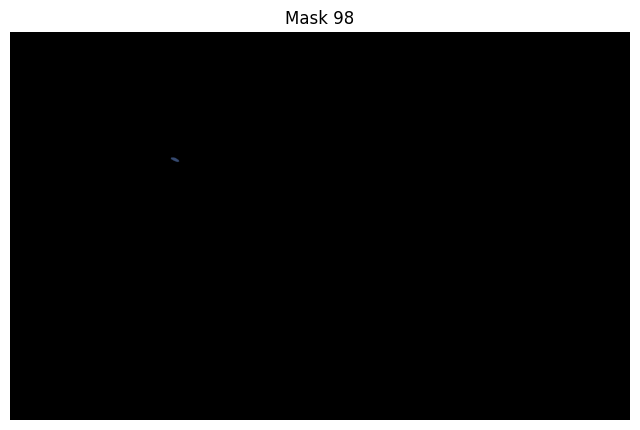

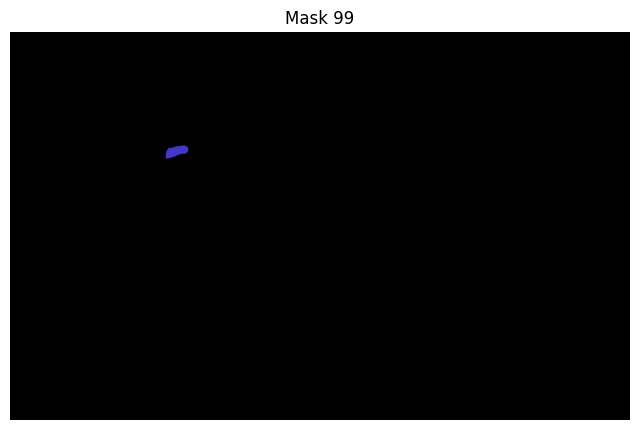

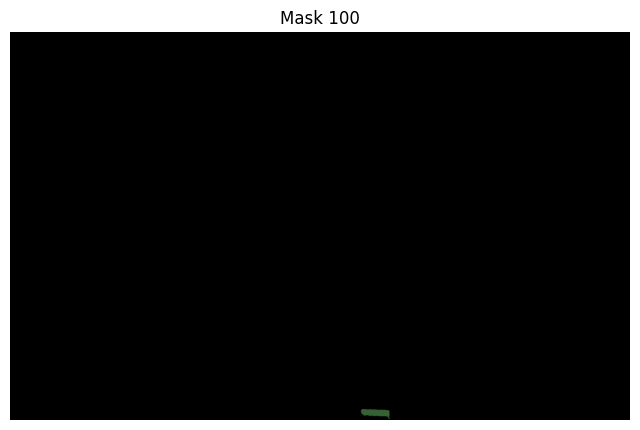

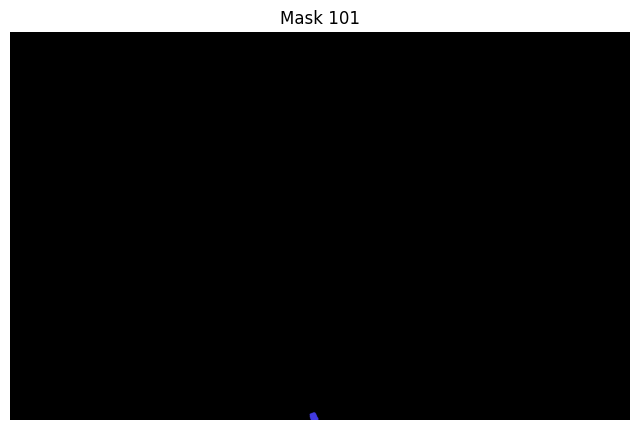

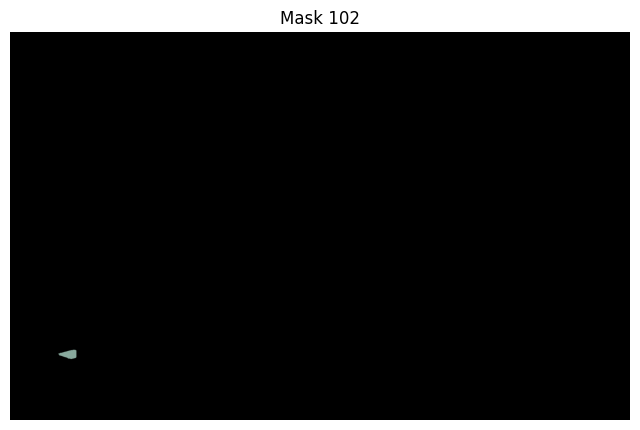

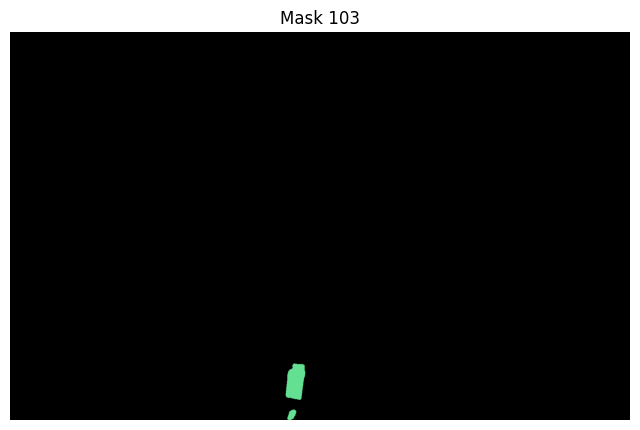

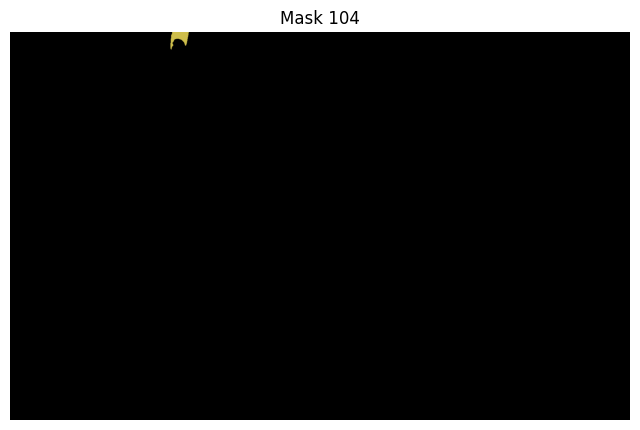

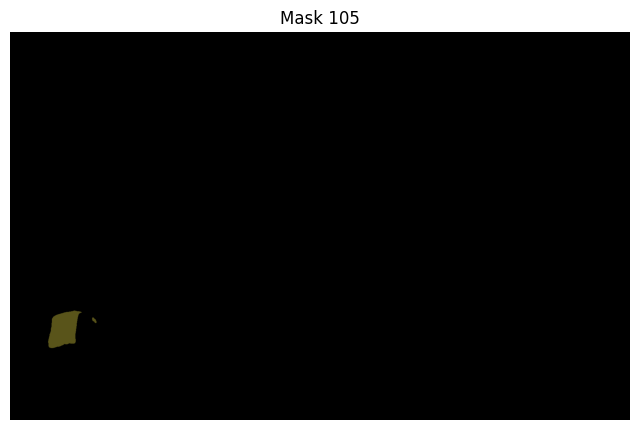

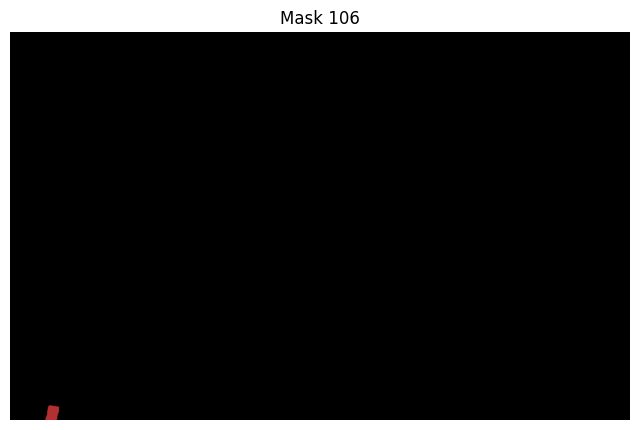

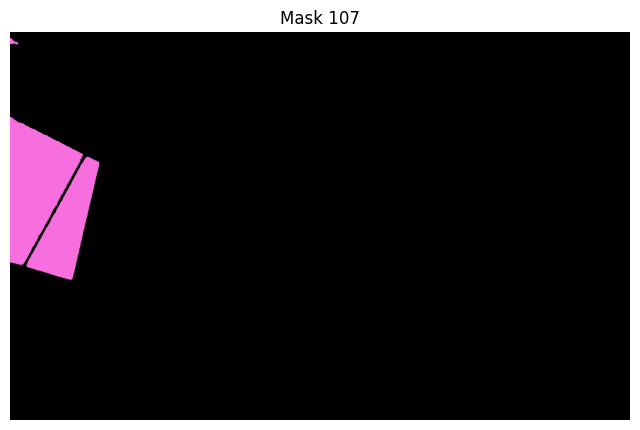

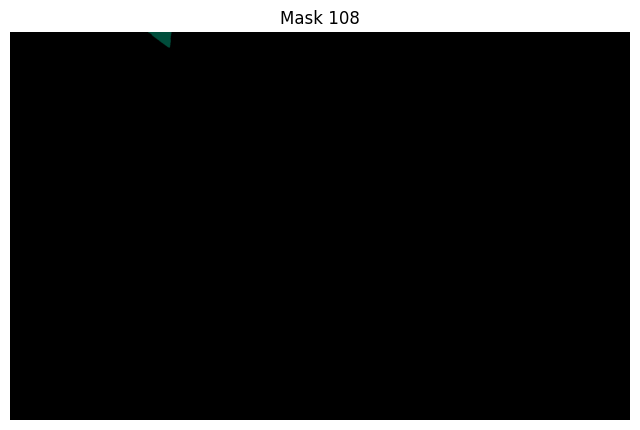

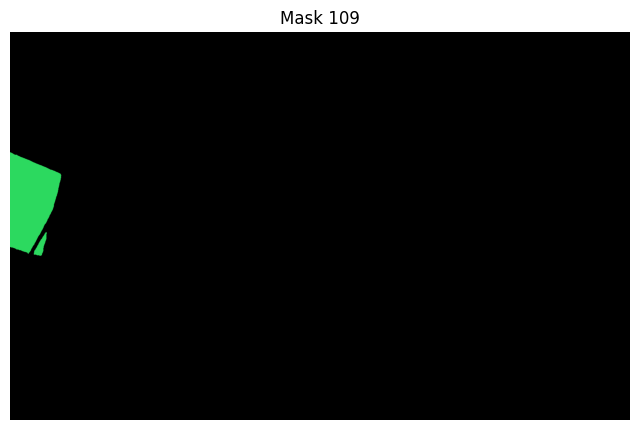

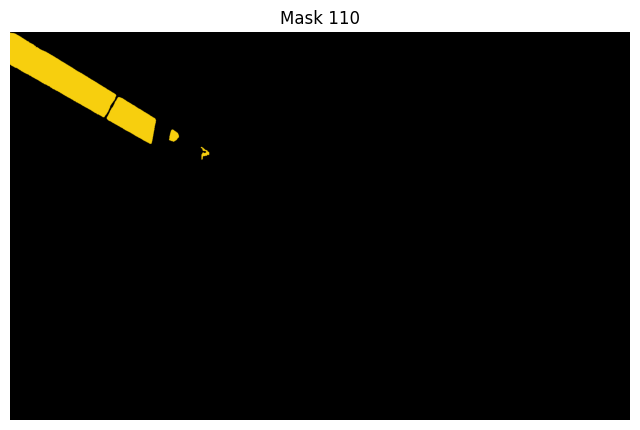

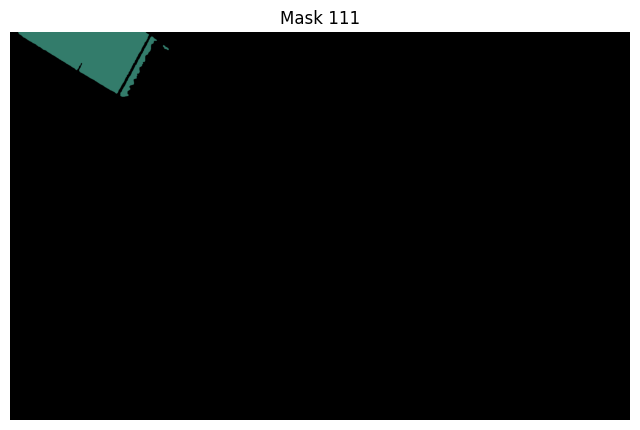

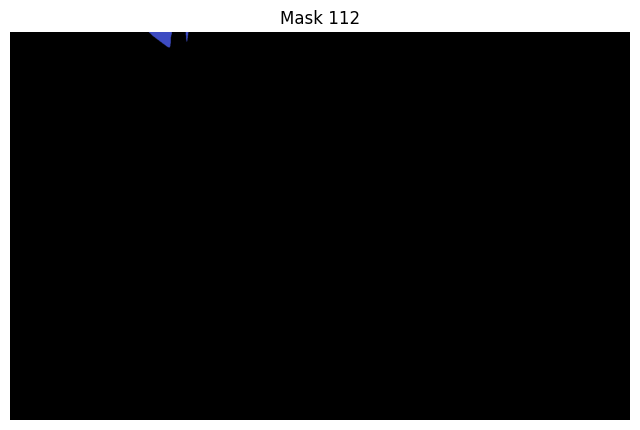

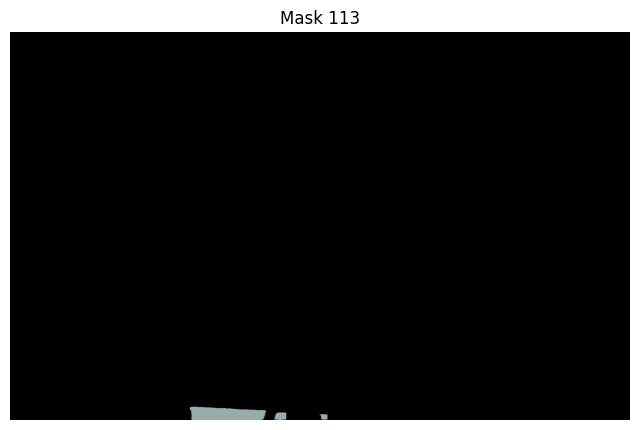

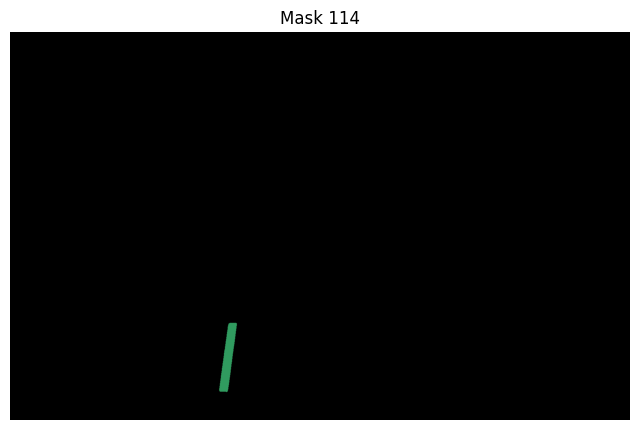

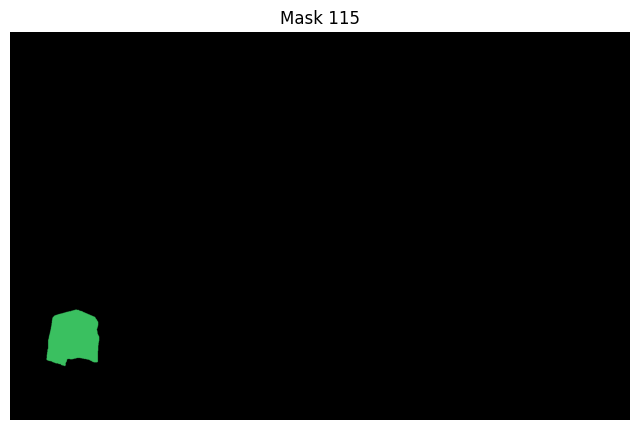

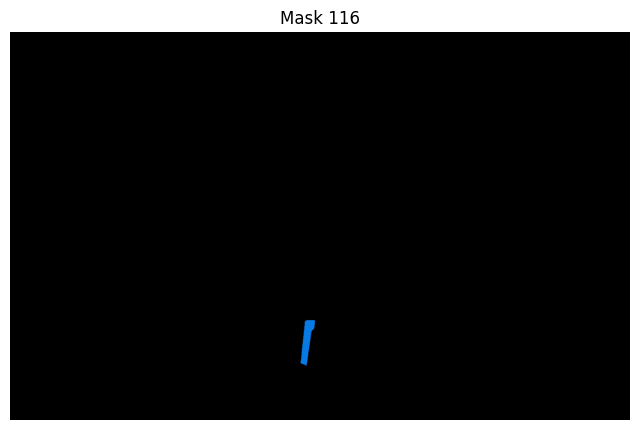

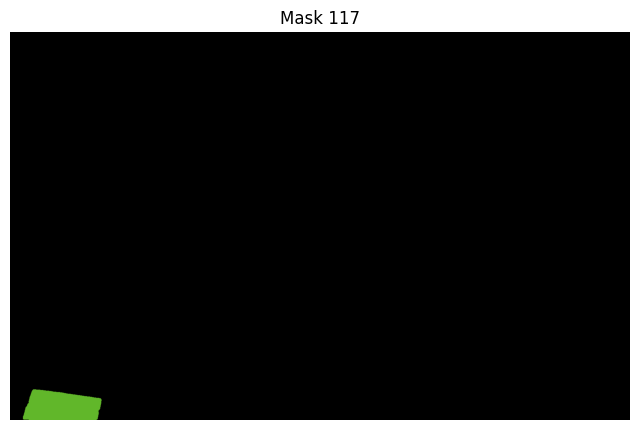

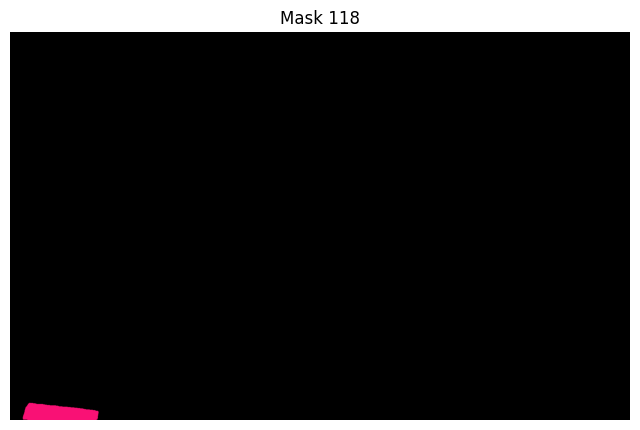

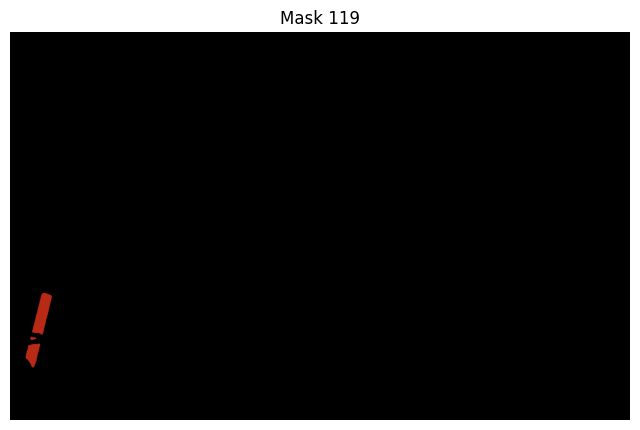

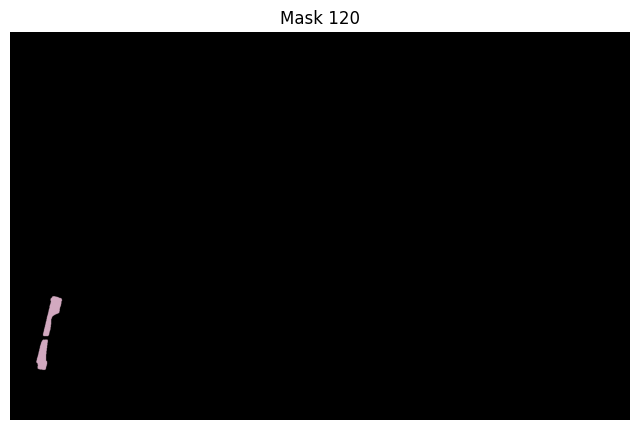

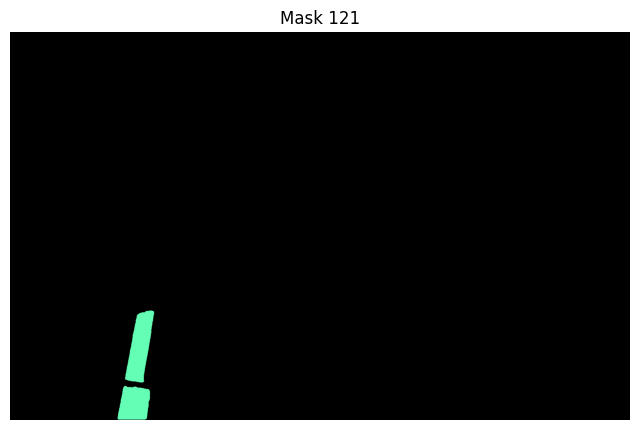

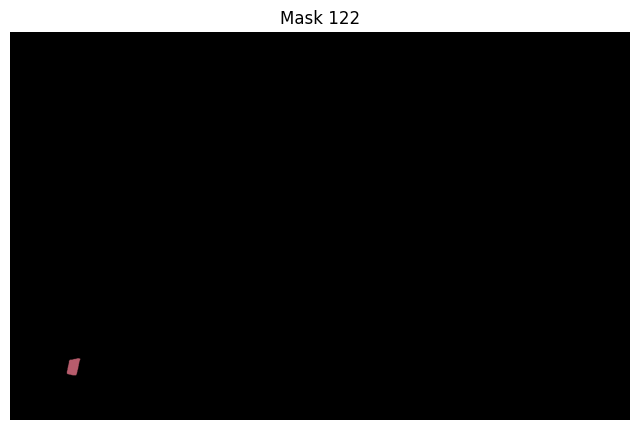

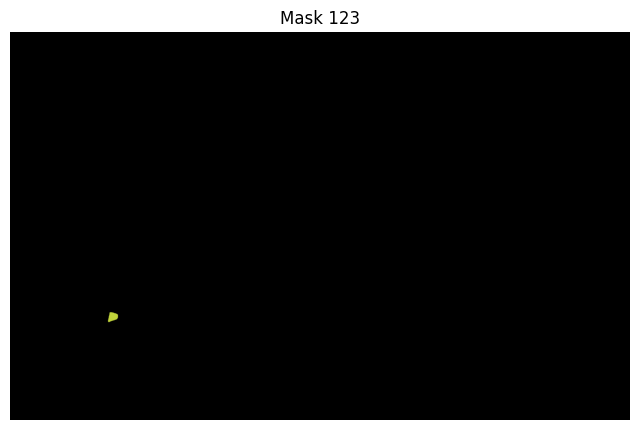

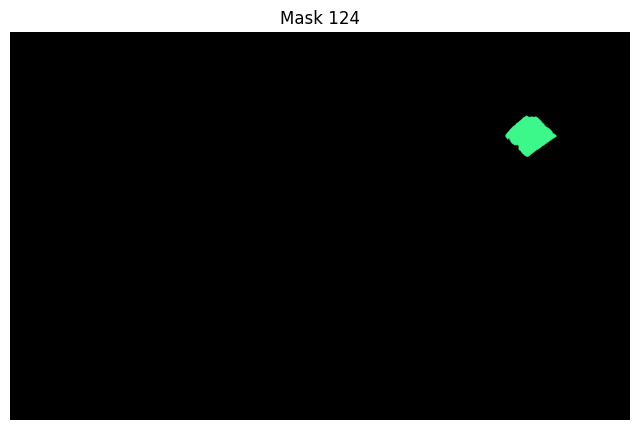

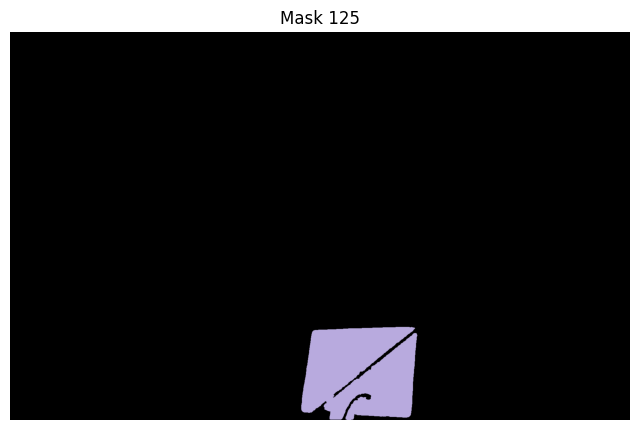

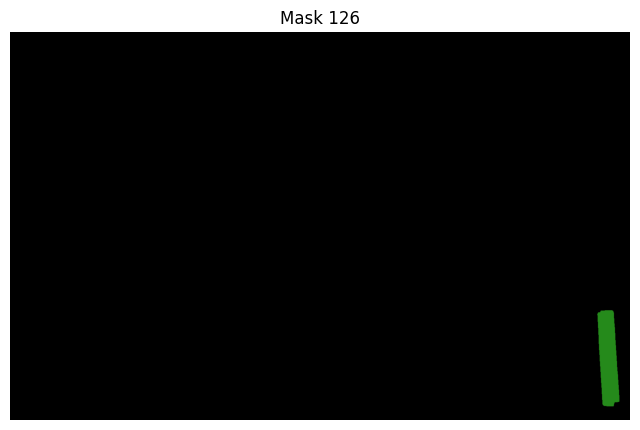

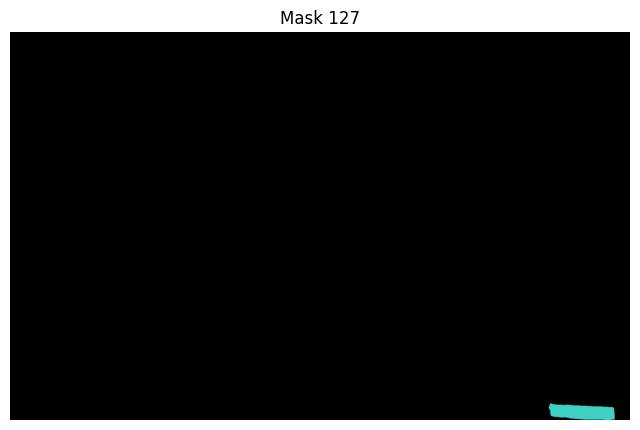

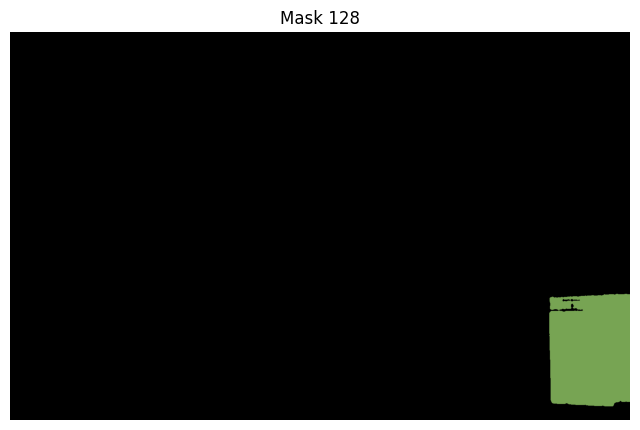

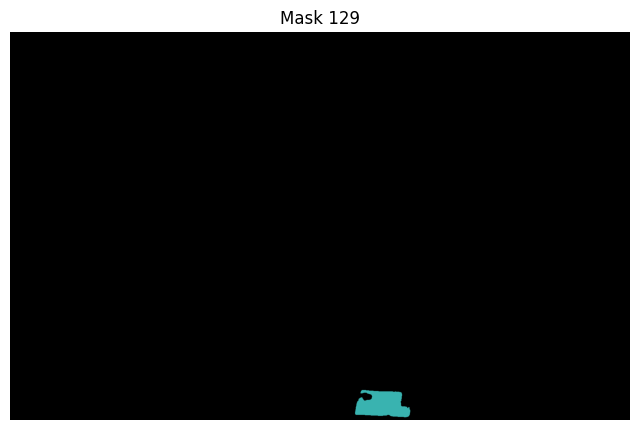

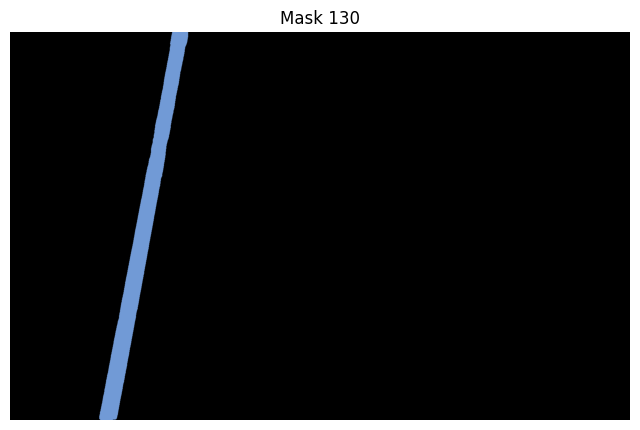

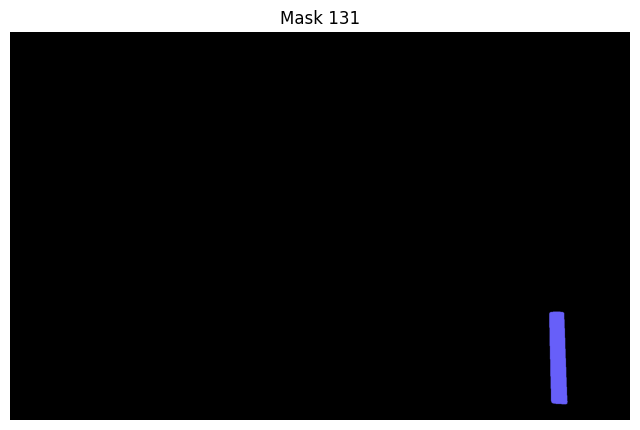

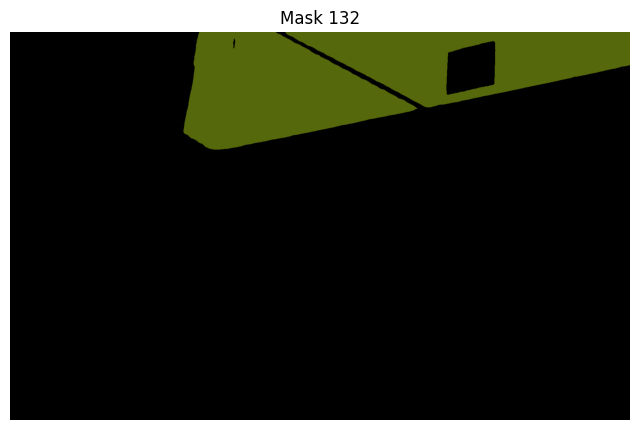

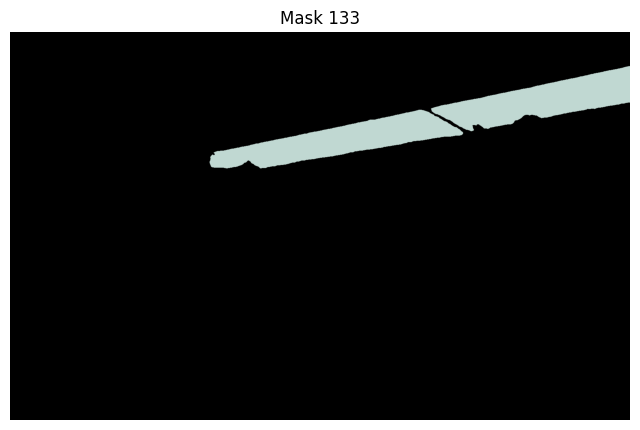

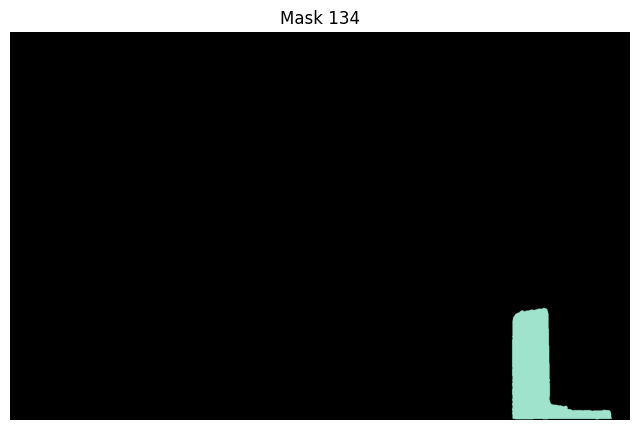

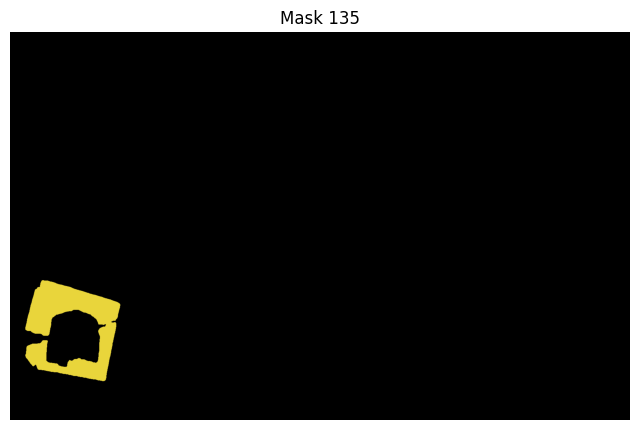

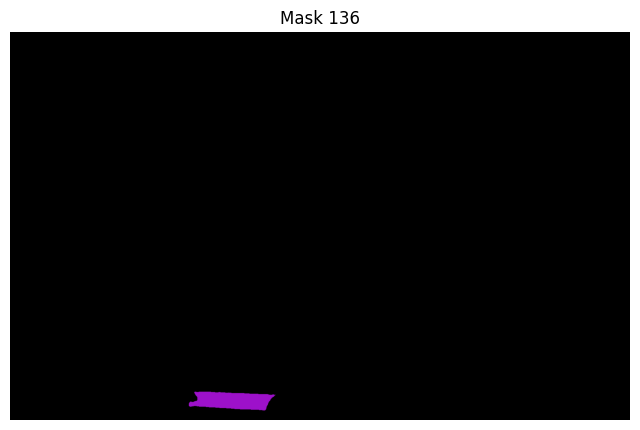

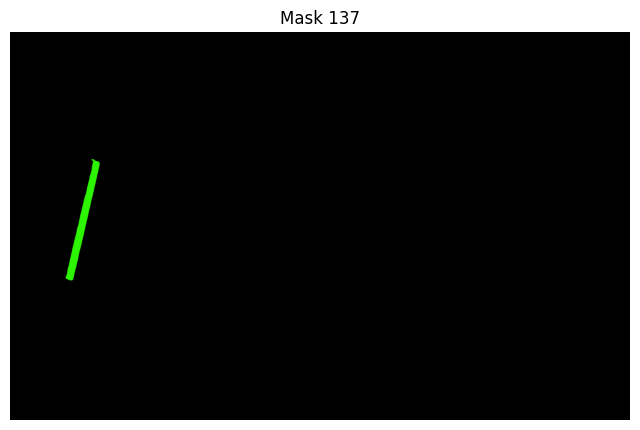

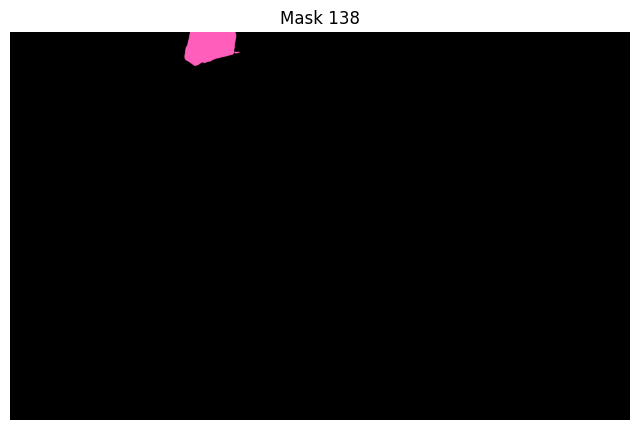

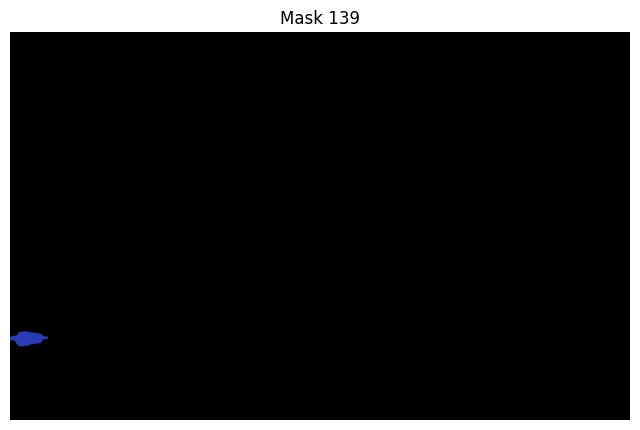

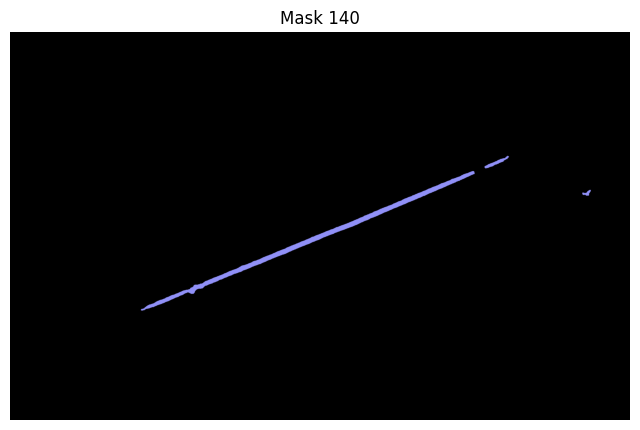

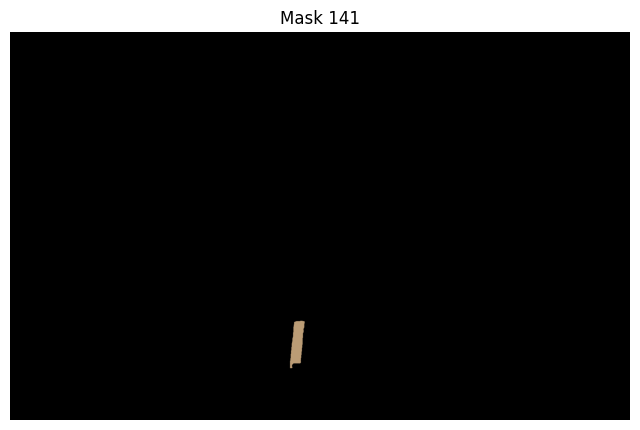

Enter the index of the mask you want to analyze: 140


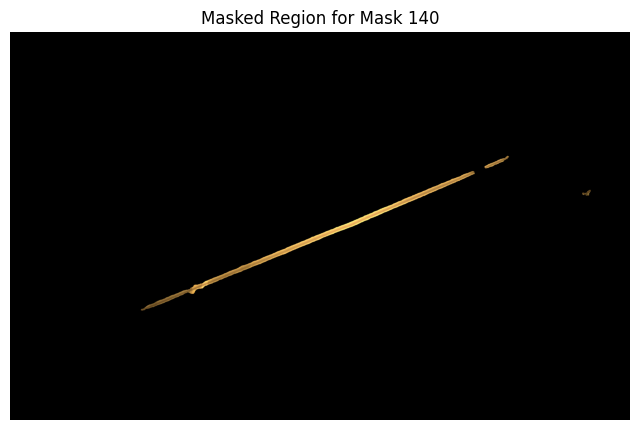

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

image = cv2.imread("/content/drive/MyDrive/baumer_video0049_021.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Load the model
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# Generate masks using mask_generator_2
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)
masks2 = mask_generator_2.generate(image)

def show_anns(anns):
    if len(anns) == 0:
        return
    for i, ann in enumerate(anns):
        mask_img = np.zeros_like(image)
        mask_img[ann['segmentation']] = np.random.randint(0, 256, size=3)  # Random RGB color for mask
        plt.figure(figsize=(8, 8))
        plt.imshow(mask_img)
        plt.axis('off')
        plt.title(f'Mask {i+1}')
        plt.show()

# Display each mask in a separate image
show_anns(masks2)

def extract_masked_region(image, mask):
    masked_image = cv2.bitwise_and(image, image, mask=mask['segmentation'].astype(np.uint8))
    return masked_image

# Select a specific mask
selected_mask_index = int(input("Enter the index of the mask you want to analyze: ")) - 1
selected_mask = masks2[selected_mask_index]

# Extract the masked region
masked_region = extract_masked_region(image, selected_mask)

# Display the masked region
plt.figure(figsize=(8, 8))
plt.imshow(masked_region)
plt.axis('off')
plt.title(f'Masked Region for Mask {selected_mask_index+1}')
plt.show()


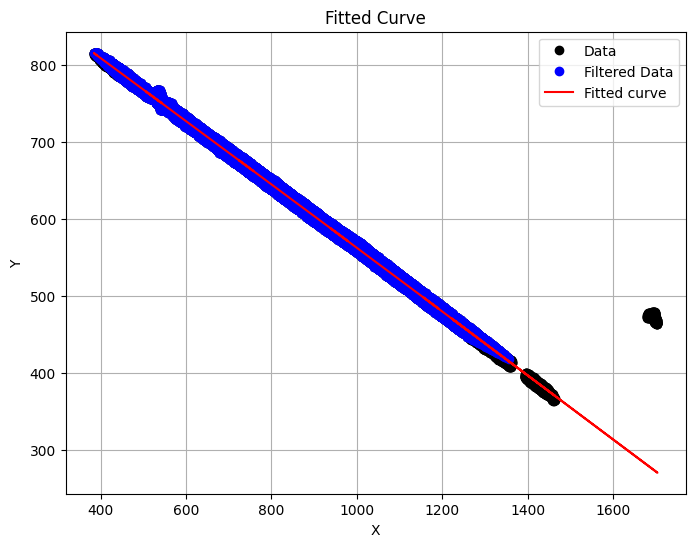

Coefficients (a, b, c): [-3.27841905e-06 -4.06479357e-01  9.72112768e+02]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a function to fit the curve
def func(x, a, b, c):
    return a * x**2 + b * x + c  # Quadratic function, you can adjust the degree as needed

# Calculate the first derivative of the curve
def derivative(x, a, b):
    return 2 * a * x + b

# Extract the masked region
# masked_region is the image where only the curve is visible
# Assuming the curve lies along the horizontal axis (x-axis)
gray_masked_region = cv2.cvtColor(masked_region, cv2.COLOR_RGB2GRAY)
nonzero_indices = np.nonzero(gray_masked_region)
x_data = nonzero_indices[1]
y_data = nonzero_indices[0]

# Fit the curve to the data
popt, pcov = curve_fit(func, x_data, y_data)

# Calculate the first derivative of the curve
derivative_values = derivative(x_data, *popt[:-1])  # Exclude the last parameter c

# Find significant changes in the derivative
threshold = 0.1  # Adjust as needed
significant_changes = np.where(np.abs(np.diff(derivative_values)) > threshold)[0]

# Calculate tangent points
tangent_points_x = x_data[significant_changes]
tangent_points_y = func(tangent_points_x, *popt)

# Plot the curve and tangent points
plt.figure(figsize=(8, 6))
plt.plot(x_data, y_data, 'ko', label='Data')
plt.plot(x_data, func(x_data, *popt), 'r-', label='Fitted curve')
plt.plot(tangent_points_x, tangent_points_y, 'bo', label='Tangent Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Curve and Tangent Points')
plt.legend()
plt.grid(True)
plt.show()

# Print tangent points
print("Tangent Points (x, y):")
for i, (x, y) in enumerate(zip(tangent_points_x, tangent_points_y)):
    print(f"Point {i+1}: ({x}, {y})")


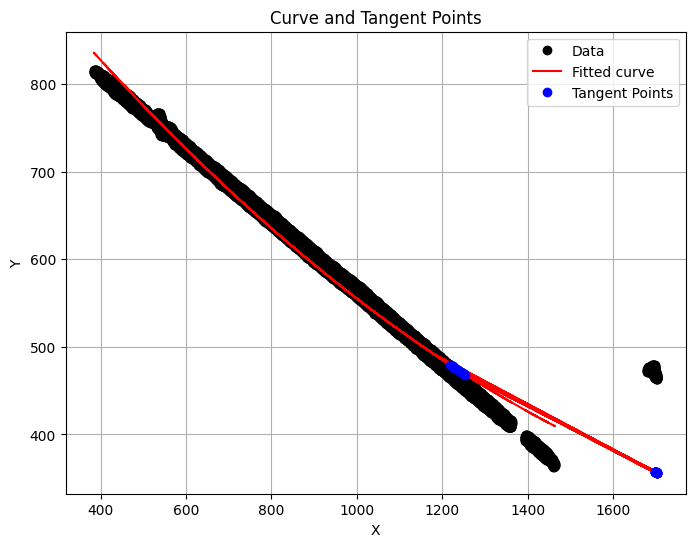

Tangent Points (x, y):
Point 1: (1254, 468.32119070787303)
Point 2: (1704, 356.304768394863)
Point 3: (1252, 468.93781772394425)
Point 4: (1704, 356.304768394863)
Point 5: (1250, 469.5554958572741)
Point 6: (1704, 356.304768394863)
Point 7: (1248, 470.17422510786287)
Point 8: (1704, 356.304768394863)
Point 9: (1245, 471.10428982860606)
Point 10: (1703, 356.4946998216351)
Point 11: (1243, 471.7256468723415)
Point 12: (1703, 356.4946998216351)
Point 13: (1240, 472.6596532828048)
Point 14: (1702, 356.6848940277216)
Point 15: (1238, 473.2836381196871)
Point 16: (1701, 356.87535101312324)
Point 17: (1236, 473.90867407382814)
Point 18: (1701, 356.87535101312324)
Point 19: (1233, 474.84819884989986)
Point 20: (1700, 357.06607077783906)
Point 21: (1230, 475.79008863980357)
Point 22: (1699, 357.25705332186976)
Point 23: (1228, 476.4193290629795)
Point 24: (1699, 357.25705332186976)
Point 25: (1226, 477.04962060341416)
Point 26: (1699, 357.25705332186976)
Point 27: (1224, 477.6809632611074)
Poin

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define a function to fit the curve
def func(x, a, b, c):
    return a * x**2 + b * x + c  # Quadratic function, you can adjust the degree as needed

# Calculate the first derivative of the curve
def derivative(x, a, b):
    return 2 * a * x + b

# Extract the masked region
# masked_region is the image where only the curve is visible
# Assuming the curve lies along the horizontal axis (x-axis)
gray_masked_region = cv2.cvtColor(masked_region, cv2.COLOR_RGB2GRAY)
nonzero_indices = np.nonzero(gray_masked_region)
x_data = nonzero_indices[1]
y_data = nonzero_indices[0]

# Fit the curve to the data
popt, pcov = curve_fit(func, x_data, y_data)

# Calculate the first derivative of the curve
derivative_values = derivative(x_data, *popt[:-1])  # Exclude the last parameter c

# Find significant changes in the derivative
threshold = 0.1  # Adjust as needed
significant_changes = np.where(np.abs(np.diff(derivative_values)) > threshold)[0]

# Calculate tangent points
tangent_points_x = x_data[significant_changes]
tangent_points_y = func(tangent_points_x, *popt)

# Plot the curve and tangent points
plt.figure(figsize=(8, 6))
plt.plot(x_data, y_data, 'ko', label='Data')
plt.plot(x_data, func(x_data, *popt), 'r-', label='Fitted curve')
plt.plot(tangent_points_x, tangent_points_y, 'bo', label='Tangent Points')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Curve and Tangent Points')
plt.legend()
plt.grid(True)
plt.show()

# Print tangent points
print("Tangent Points (x, y):")
for i, (x, y) in enumerate(zip(tangent_points_x, tangent_points_y)):
    print(f"Point {i+1}: ({x}, {y})")


In [ ]:
import numpy as np
import cv2
import os  # Importing os module
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img

# Define U-Net model with input shape (1920, 1200, 3)
def unet(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom (bottle-neck)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    # Decoder
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(drop5))
    merge6 = layers.concatenate([drop4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(num_classes, 3, activation='relu', padding='same')(conv9)

    output = layers.Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = models.Model(inputs=inputs, outputs=output)

    return model

# Function to predict on full-size image
def predict_full_image(model, image, patch_size=(224, 224)):
    predictions = []
    height, width = image.shape[:2]
    stride = patch_size[0] // 2

    for y in range(0, height - patch_size[0] + 1, stride):
        for x in range(0, width - patch_size[1] + 1, stride):
            patch = image[y:y+patch_size[0], x:x+patch_size[1]]
            if patch.shape[:2] != patch_size:
                patch = cv2.resize(patch, patch_size)
            patch = np.expand_dims(patch, axis=0)
            prediction = model.predict(patch)
            predictions.append(prediction)

    return predictions

# Load video
cap = cv2.VideoCapture('/content/drive/MyDrive/baumer_video0049.avi')
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)
cap.release()

# Load labels
X = []
Y = []
for i, frame in enumerate(frames, 1):
    # Extract corresponding label file name
    label_file = f"baumer_video0049_Label_{i}.png"
    label_path = os.path.join('/content/drive/MyDrive/PixelLabelData', label_file)
    if os.path.exists(label_path):
        img = load_img(label_path, color_mode='grayscale', target_size=(224, 224))
        label_array = img_to_array(img)
        Y.append(label_array)
        # Resize input image to match the model's input shape
        resized_frame = cv2.resize(frame, (224, 224))
        X.append(resized_frame)
    else:
        print(f"No label found for frame: {label_file}")

# Convert to numpy arrays
X = np.array(X) / 255.0
Y = np.array(Y) / 255.0  # Assuming labels are in the range [0, 255]

# Convert labels to categorical
Y = to_categorical(Y, num_classes=2)  # Assuming 2 classes: background and cable

# Split the data into training and validation sets
if len(X) > 0 and len(Y) > 0:
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
else:
    print("Data loading failed. Check the paths or the data loading process.")

# Define the model
model = unet(input_shape=(224, 224, 3), num_classes=2)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with reduced batch size
model.fit(X_train, Y_train, batch_size=8, epochs=30, validation_data=(X_val, Y_val))

# Save the model
model.save('/content/trained_unet.h5')


No label found for frame: baumer_video0049_Label_2.png
No label found for frame: baumer_video0049_Label_3.png
No label found for frame: baumer_video0049_Label_4.png
No label found for frame: baumer_video0049_Label_5.png
No label found for frame: baumer_video0049_Label_11.png
No label found for frame: baumer_video0049_Label_12.png
No label found for frame: baumer_video0049_Label_13.png
No label found for frame: baumer_video0049_Label_14.png
No label found for frame: baumer_video0049_Label_15.png
No label found for frame: baumer_video0049_Label_16.png
No label found for frame: baumer_video0049_Label_17.png
No label found for frame: baumer_video0049_Label_18.png
No label found for frame: baumer_video0049_Label_19.png
No label found for frame: baumer_video0049_Label_20.png
No label found for frame: baumer_video0049_Label_21.png
No label found for frame: baumer_video0049_Label_22.png
No label found for frame: baumer_video0049_Label_23.png
No label found for frame: baumer_video0049_Label_24.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load the trained model
model = load_model('trained_unet.h5')

# Load and preprocess the test image
test_image_path = '/content/drive/MyDrive/baumer_video0049_021.png'
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (1920, 1200))  # Resize to match model input shape
test_image = test_image / 255.0  # Normalize

# Make prediction
prediction = model.predict(np.expand_dims(test_image, axis=0))

# Post-processing if needed
# For example, converting prediction to binary mask
binary_prediction = np.argmax(prediction[0], axis=-1)

# Visualize or save the result
# For example, saving the prediction as an image
cv2.imwrite('prediction.jpg', binary_prediction * 255)
